In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    os.environ['CUDA_VISIBLE_DEVICES'] = \
        os.environ['CUDA_VISIBLE_DEVICES'].split(',')[1]
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/minoconda3_x86/envs/open-instruct/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1,2
2
Thu Nov 23 11:34:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   31C    P0    42W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:16:00.0 Off |                    0 |
| 

In [8]:
import os
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm

log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 1
test_run = bool(test_run)

# model_name = 'llama-7b'; encode_fn_type = 'sft'; md = 'llama7b'
# model_name = 'llama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'llama7b'
# model_name = 'mistral-7b+lora:r=256:a=256'; encode_fn_type = 'sft'; md = 'mistral7b'
model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'; md = 'mpnet'
# model_name = 'bge-large-en-v1.5'; encode_fn_type = 'input'; md = 'bge'


sort_by_list = [
    f'dppmapbd_nc=200_k=vmf_gamma={gamma}_kmd=mpnet' 
    for gamma in [.3, 1., 3., 10.]] # [.3, 1., 3., 10., 15.]
sort_by_list += [f'dppmapbd_nc=200_k=lin_kmd=mpnet']
# sort_by_list = [
#     f'dppmap_theta={theta}_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b' for theta in [0, .3, .6, .9, .95]
# ]


# nc_list = [100, 500, 1000]
# nc_list = [100, 200, 300, 400, 500, 600]
# sort_by_list = [
#     f'semdedup_cl=kmeansfaisscd_md={md}_dist=cd_emb={emb}_nc={nc}'
#     for nc in nc_list
#     for emb in ['text+embedding', 'grad+rp+loraB'] # 'grad+rp+loraB' 
# ]

# sort_by_list = [
#     'random_s=0', 'random_s=1', 'random_s=2',
#     'log_prob', 'logit_margin', 'el2n_agg=mean',
#     'grad_loraB_l2n', 'numtoks'
# ]
# sort_by_list += [
# #     'kmeansl2_emb=grad+rp+loraB_nc=300',
# #     'kmeansl2_emb=grad+rp+loraB_nc=1000',
#     'kmeansl2_emb=grad+rp+loraB_nc=3000',
# #     'kmeansl2_emb=text+embedding_nc=300',
#     'kmeansl2_emb=text+embedding_nc=1000',
# #     'kmeansl2_emb=text+embedding_nc=3000',
# ]
# sort_by_list = ['numtoks']

# sort_by_list += [
#     'dppmap_emb=grad+rp+loraB_k=Kcos', 
#     'dppmap_emb=text+embedding_k=Kcos', 
#     'dppmap_emb=grad+rp+loraB_k=Kcosp', 
#     'dppmap_emb=text+embedding_k=Kcosp',
#     'dppmap_emb=grad+rp+loraB_k=Kcos1np', 
#     'dppmap_emb=text+embedding_k=Kcos1np',
# ]
# dataset_list = ['lima']
# dataset_list = ['flan2022_1m']
# dataset_list = ['tulu_v1_mix']
# dataset_list = ['ultrachat']
dataset_list = ['ultrachat15']
# dataset_list = ['wizardlm']
# dataset_list = ['sharegpt']


# sort_by_list = [
#  'log_prob',
#  'el2n_agg=mean',
#  'el2n_agg=l2n',
#  'logit_margin',
# ]
# if 'lora' in model_name:
#     sort_by_list += ['grad_loraB_l2n']
# else:
#     sort_by_list += ['grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',]
# sort_by_list = ['kmeansl2_emb=grad+rp+loraB_nc=30',
#                 'kmeansl2_emb=text+embedding_nc=30']
# dataset_list = ['lima']


# model_name = 'pythia-1b-deduped'
# model_name = 'pythia-1b-deduped+lora:r=256:a=256'
# dataset_list = ['cot', 'dolly', 'flan_v2', 'lima', 'oasst1']
# # sort_by_list = ['random_s=0', 
# #                 'log_prob', 'logit_margin', 'el2n_agg=mean', 'el2n_agg=l2n', 
# #                 'kmeansl2_nc=3000', 'kmeanscd_nc=3000',
# #                 'grad_loraB_l2n',
# #                 'grad_all_l2n', 'grad_qkv_l2n', 'grad_mlp_l2n', 'grad_last_l2n',
# #                ]
# sort_by_list = ['grad_loraB_l2n']

from note_pruning_analysis import data_inds_dir

options_list = itertools.product(dataset_list, sort_by_list)

print('test_run =',test_run)
cmds = []
for dataset, sort_by in options_list:
    save_dir = os.path.join(data_inds_dir, model_name, dataset)
    cmd = f"""
     python note_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --model_name {model_name} \
        --encode_fn_type {encode_fn_type} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=64, # 32
        cpu_mem=256, # 128
        num_gpus=1,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    cmds.append(cmd)
    print(cmd)
        
print('#cmds: ', len(cmds))


test_run = True

Submiting job with:
{
    "job_name": "prune.ultrachat15.dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 256,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": true,
    "queue": "x86_6h",
    "num_jobs": 1
}
python note_pruning.py --dataset ultrachat15 --sort_by dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet --model_name all-mpnet-base-v2 --encode_fn_type input --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/all-mpnet-base-v2/ultrachat15

Submiting job with:
{
    "job_name": "prune.ultrachat15.dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 256,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": true,
    "queue": "x86_6h",
    "num_jobs": 1
}
python note_pruning.py --dataset ultrachat15 --sort_by dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet --model_name all-mpnet-base-v2 --encode_fn_type input --save_dir /gpf

In [9]:
!CUDA_VISIBLE_DEVICES=1 python note_pruning.py --dataset ultrachat15 --sort_by dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet --model_name all-mpnet-base-v2 --encode_fn_type input --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/all-mpnet-base-v2/ultrachat15


{
  "dataset": "ultrachat15",
  "sort_by": "dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet",
  "model_name": "all-mpnet-base-v2",
  "save_dir": "/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/all-mpnet-base-v2/ultrachat15",
  "encode_fn_type": "input",
  "test_run": false
}
Calling note_pruning_dpp.compute_dppmap with kwargs={
    "dppmap_type": "dppmapbd",
    "dataset": "ultrachat15",
    "kernel_type": "vmf",
    "kernel_embed_model": "mpnet",
    "kernel_embed_type": "text_embedding",
    "kernel_kwargs": {
        "gamma": 1.0
    },
    "quality_score_type": null,
    "quality_score_embed_model": null,
    "theta": 0.0,
    "device": "cuda",
    "max_length": 5000
}
dppmapbd: cluster = 0 / 200
/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/note_pruning_dpp.py:199: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future re

100%|██████████████████████████████████████| 4999/4999 [00:09<00:00, 514.09it/s]
dppmapbd: cluster = 64 / 200
100%|██████████████████████████████████████| 4999/4999 [00:08<00:00, 567.35it/s]
dppmapbd: cluster = 65 / 200
100%|██████████████████████████████████████| 4999/4999 [00:09<00:00, 513.53it/s]
dppmapbd: cluster = 66 / 200
100%|██████████████████████████████████████| 4999/4999 [00:08<00:00, 587.27it/s]
dppmapbd: cluster = 67 / 200
100%|██████████████████████████████████████| 4999/4999 [00:09<00:00, 542.21it/s]
dppmapbd: cluster = 68 / 200
100%|██████████████████████████████████████| 4999/4999 [00:09<00:00, 545.09it/s]
dppmapbd: cluster = 69 / 200
100%|██████████████████████████████████████| 4999/4999 [00:09<00:00, 529.92it/s]
dppmapbd: cluster = 70 / 200
100%|██████████████████████████████████████| 4999/4999 [00:08<00:00, 567.49it/s]
dppmapbd: cluster = 71 / 200
100%|██████████████████████████████████████| 4999/4999 [00:09<00:00, 521.63it/s]
dppmapbd: cluster = 72 / 200
100%|█████

100%|██████████████████████████████████████| 4999/4999 [00:05<00:00, 983.96it/s]
dppmapbd: cluster = 138 / 200
100%|██████████████████████████████████████| 4999/4999 [00:05<00:00, 929.66it/s]
dppmapbd: cluster = 139 / 200
100%|██████████████████████████████████████| 4999/4999 [00:05<00:00, 919.07it/s]
dppmapbd: cluster = 140 / 200
100%|██████████████████████████████████████| 4999/4999 [00:05<00:00, 935.98it/s]
dppmapbd: cluster = 141 / 200
100%|█████████████████████████████████████| 4999/4999 [00:04<00:00, 1027.73it/s]
dppmapbd: cluster = 142 / 200
100%|██████████████████████████████████████| 4999/4999 [00:05<00:00, 911.80it/s]
dppmapbd: cluster = 143 / 200
100%|██████████████████████████████████████| 4999/4999 [00:05<00:00, 921.70it/s]
dppmapbd: cluster = 144 / 200
100%|██████████████████████████████████████| 4999/4999 [00:05<00:00, 928.13it/s]
dppmapbd: cluster = 145 / 200
100%|██████████████████████████████████████| 4999/4999 [00:05<00:00, 964.89it/s]
dppmapbd: cluster = 146 / 200
1

 99%|████████████████████████████████████▌| 3952/3993 [00:02<00:00, 1791.86it/s]
dppmapbd: cluster = 184 / 200
 99%|████████████████████████████████████▋| 3904/3942 [00:02<00:00, 1665.21it/s]
dppmapbd: cluster = 185 / 200
100%|████████████████████████████████████▉| 3864/3873 [00:02<00:00, 1769.16it/s]
dppmapbd: cluster = 186 / 200
100%|████████████████████████████████████▉| 3619/3629 [00:01<00:00, 2073.98it/s]
dppmapbd: cluster = 187 / 200
100%|████████████████████████████████████▉| 3608/3618 [00:01<00:00, 2059.31it/s]
dppmapbd: cluster = 188 / 200
100%|████████████████████████████████████▉| 3462/3469 [00:01<00:00, 2070.10it/s]
dppmapbd: cluster = 189 / 200
100%|████████████████████████████████████▉| 3423/3426 [00:01<00:00, 2224.63it/s]
dppmapbd: cluster = 190 / 200
100%|████████████████████████████████████▊| 3271/3286 [00:01<00:00, 2195.49it/s]
dppmapbd: cluster = 191 / 200
 95%|███████████████████████████████████  | 3027/3191 [00:01<00:00, 2341.65it/s]
dppmapbd: cluster = 192 / 200
1

In [ ]:
with open('note_pruning_run_cmds.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES']
    devices = 1
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

### Generate curriculum from pre-computed scores (via `note_pruning.py`)

In [60]:
import itertools
from note_curriculum import (
    get_curriculum_scores,
    get_curriculum,
    generate_curriculum,
    generate_curriculum_forall_scoring_fn,
    scores_path_to_attrs,
    np_random_choice_maximize_noreplacement,
    plt_curriculum,
)
from note_pruning_analysis import assets_dir

# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000
# model_name = 'llama-7b'; dataset = 'sharegpt'; M = 150_000

## mistral+ultrachat
# model_name = 'mistral-7b'; dataset = 'ultrachat200k'; M = 50_000
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000
model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 200_000 # 400_000 # 

## semdedup
# model_name = 'llama-7b'; dataset = 'wizardlm'; M = 100_000
# model_name = 'all-mpnet-base-v2'; dataset = 'wizardlm'; M = 100_000
# model_name = 'bge-large-en-v1.5'; dataset = 'wizardlm'; M = 100_000
# model_name = 'all-mpnet-base-v2'; dataset = 'ultrachat15'; M = 100_000
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000


pacing_fn_list = [
#     f'prune_size={M}_ep=1',
    f'prune_size={M}_ep=2',
#     f'prune_size={M}_ep=3',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.05',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
]

output_list = generate_curriculum_forall_scoring_fn(
    model_name, dataset, pacing_fn_list, verbose=False)

save inds (length = 400000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input/inds_prune_size=400000_ep=2.pkl
save inds (length = 400000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_total_neg/inds_prune_size=400000_ep=2.pkl
save inds (length = 400000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=500/inds_prune_size=400000_ep=2.pkl
save inds (length = 400000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/numtoks_input_neg/inds_prune_size=400000_ep=2.pkl
save inds (length = 400000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/el2n_agg=mean_neg/inds_prune_size=400000_ep=2.pkl
save inds (length = 400000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeansfaisscd_md=mistral7b_dist=cd_emb=grad+rp+loraB_nc=600_neg/inds_prune_size=400000_ep=2.pkl
save inds (length = 400000) to curriculum/mistral-7b+lora:r=256:a=256/ultrachat15/semdedup_cl=kmeans

In [ ]:
1

In [ ]:
import re
import numpy as np
from note_curriculum import get_curriculum_scores, generate_curriculum, plt_curriculum
import glob
import matplotlib.pyplot as plt

model_name = 'mistral-7b'; dataset = 'ultrachat'; M =  50_000
# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000


paths = glob.glob('curriculum/*/*/*/scores.pkl')
paths = [x for x in paths if 'llama' in x and 'tulu_v1_mix' in x and 'log_prob_neg' in x]
path = paths[0]

verbose = True
print(path)
pacing_fn = f'prune_size={M}_ep=3'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.1'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.2'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.3'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.2_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'

pacing_fn_list = [
    f'prune_size={M}_ep=3',
    f'singlestep_size={M}_startingfrac=0.05',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.2',
#     f'singlestep_size={M}_startingfrac=0.3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=3',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.25'
]



nrows = len(pacing_fn_list)
fig, axs = plt.subplots(nrows, 3, figsize=(15,3*nrows), sharey=False, gridspec_kw={'width_ratios': [2,.5,.5]})

for i, pacing_fn in enumerate(pacing_fn_list):

    plt_kwargs = generate_curriculum(path, pacing_fn, verbose=True, save_output=False)
    output = plt_kwargs.pop('output')
    plt_kwargs.update({'fig': fig, 'axs': axs[i]})
    plt_curriculum(**plt_kwargs)

fig.tight_layout()



save_plt = 0
if save_plt:
    model_name, dataset, scoring_fn = output['model_name'], output['dataset'], output['scoring_fn']
    save_path = os.path.join(
        assets_dir, f'note_curriculum_{model_name}:{dataset}:{scoring_fn}.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)



### main code

In [28]:
import os
import sys
import numpy as np
import time
import re
import random
import json
import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers
import pandas as pd

from note_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_dist_to_cluster_centers,
    sort_dpp_map,
    save_prune_results,
    sort_dpp_map_memefficient,
)
from note_pruning_analysis import get_lm_output
from note_pruning_dpp import torch_vmf_kernel, torch_rbf_kernel
from functools import partial

from transformers import AutoTokenizer

from rosemary import parse_kv_from_string, create_string_from_kv
from note_pruning_analysis import lm_output_dir, get_dataset_token_lengths

import note_pruning_dpp
import note_pruning_clustering

In [25]:
test_run = False
dataset = 'tulu_v1_human_mix'
dataset = 'tulu_v2_human_mix'
dataset = 'flan_v2'
dataset = 'lima'
dataset = 'flan2022_1m'
dataset = 'tulu_v1_mix'
dataset = 'lima'
dataset = 'ultrachat200k'
dataset = 'wizardlm'
# dataset = 'ultrachat15'

# sort_by = 'random_s=0'
# sort_by = 'kmeansl2_nc=3000'
# sort_by = 'kmeanscd_nc=3000'
# sort_by = 'log_prob'
# sort_by = 'dppmap_k=Kcos'
# sort_by = 'dppmap_k=Kcos1np'
# sort_by = 'el2n'
# sort_by = 'grad_norm'
# sort_by = 'kmeansl2_emb=grad+rp+loraB_nc=3000'
# sort_by = 'kmeansl2_emb=text+embedding_nc=3000'
sort_by = 'dppmap_emb=text+embedding_k=Kcos'
# sort_by = 'logit_margin'
# rhov1: mistral-7b base-tuned(ultrachat200k_beforesplitlongconv)
# sort_by = 'rhov1'
# sort_by = 'numtoks'
# sort_by = 'semdedup_cl=kmeansfaisscd_md=mpnet_dist=cd_emb=text+embedding_nc=200'

# used for generating model output.
# model_name = 'llama-7b'; encode_fn_type = 'sft'
# model_name = 'llama-7b_ft=hmv1'; encode_fn_type = 'sft'
# model_name = 'llama-7b+lora:r=256:a=256'; encode_fn_type = 'sft'
# model_name = 'mistral-7b+lora:r=256:a=256'; encode_fn_type = 'sft'
model_name = 'all-mpnet-base-v2'; encode_fn_type = 'input'
# model_name = 'bge-large-en-v1.5'; encode_fn_type = 'input'

# model_name = 'mistral-7b+lora:r=256:a=256__rho__mistral-7b-ultrachat200k-v1+lora:r=256:a=256'


save_dir = f"data_inds/"
save_dir = os.path.join(save_dir, '' if encode_fn_type=='sft' else encode_fn_type, model_name, dataset)
os.makedirs(save_dir, exist_ok=True) 

print(dataset, model_name, sort_by)
print(save_dir)

wizardlm all-mpnet-base-v2 dppmap_emb=text+embedding_k=Kcos
data_inds/input/all-mpnet-base-v2/wizardlm


In [161]:
sort_by_list = [
    'dppmapbd_nc=200_k=lin_kmd=mpnet',
]
sort_by_list += [
    f'dppmapbd_nc=200_k=vmf_gamma={gamma}_kmd=mpnet' for gamma in [.3, 1., 3., 10., 15.]
]

infos = {}
for sort_by in sort_by_list:
    path = f'data_inds/all-mpnet-base-v2/ultrachat15/{sort_by}_incr.pkl'
    with open(path, 'rb') as f:
        d = pickle.load(f)
    info = d['info']
    infos[sort_by] = info

dppmapbd_nc=200_k=lin_kmd=mpnet
156326 5000
2.9915136678937415e-07
dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet
955220 5000
2.652129751368193e-07
dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet
955330 5000
3.2768440405561705e-07
dppmapbd_nc=200_k=vmf_gamma=3.0_kmd=mpnet
955449 5000
7.163745294747059e-07
dppmapbd_nc=200_k=vmf_gamma=10.0_kmd=mpnet
955905 5000
1.9072674604103668e-06
dppmapbd_nc=200_k=vmf_gamma=15.0_kmd=mpnet
956101 5000
3.57563038733133e-07


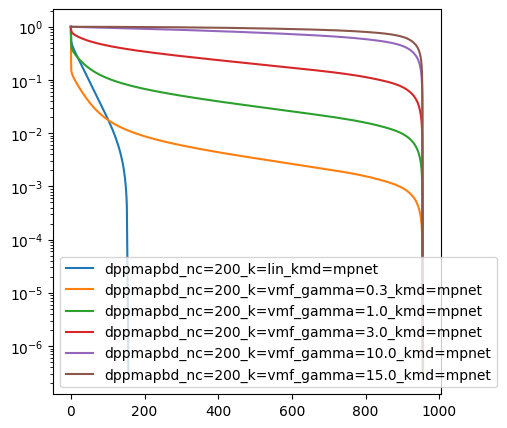

In [164]:
import matplotlib.pyplot as plt

spacings = 1000
fig, ax = plt.subplots(1,1,figsize=(5,5))

for sort_by, info in infos.items():
    print(sort_by)
    M = info['M']
    max_length = info['max_length']
    print(M, max_length)
    ys = info['marginal_gains'][::spacings]
    print(np.array(ys).min())
    ax.plot(ys, label=sort_by)
    ax.set_yscale('log')
    
# ax.set_xlim((0, 200_000/spacings))
ax.legend()

In [26]:
d = get_lm_output(dataset, model_name, encode_fn_type=encode_fn_type, return_text_embedding=True)
if test_run:
    d = {k: v[:1000] for k, v in d.items()}
    
# some entries are nan, impute with mean value.
N = d['text_embedding'].shape[0]
print(N)

143000


In [30]:
## the copy in `note_pruning.py` is most up to date

pkl_extra = {}
inds = None

# sort_by = 'dppmap_theta=.5_k=vmf_gamma=1.0_kmd=mpnet_q=log+prob_qmd=llama7b'


# sort_by = 'dppmap_k=vmf_gamma=1.0_kmd=mpnet'
# sort_by = 'dppmap_k=vmf_gamma=0.3_kmd=mpnet'
# sort_by = 'dppmap_k=vmf_gamma=3.0_kmd=mpnet'
# sort_by = 'dppmap_theta=.5_k=vmf_gamma=3.0_kmd=mpnet_q=log+prob_qmd=mistral7b'

sort_by = 'dppmapbd_nc=200_k=vmf_gamma=0.3_kmd=mpnet'
sort_by = 'dppmapbd_nc=200_k=lin_kmd=mpnet'


t0 = time.time()
if any(sort_by.startswith(x) for x in [
        'log_prob', 
        'el2n',  # el2n_agg={l2n|mean}
        'logit_margin', 
        'grad',  # grad_{loraB|qkv|all|last}_l2n
    ]):
    if sort_by not in d:
        print(f'sort_by={sort_by} not in model output: ({dataset}, {model_name})')
    S = np.nan_to_num(d[sort_by], nan=np.nanmean(d[sort_by])).squeeze()
elif sort_by.startswith('random'):
    match = re.search(r's=(\d+)', sort_by)
    seed = int(match.group(1))
    np.random.seed(seed)
    S = np.random.rand(N)
    assert(S.shape == np.unique(S).shape)
if sort_by.startswith('kmeans'):
    dist_fn = 'l2' if sort_by.startswith('kmeansl2') else 'cd'
    match = re.search(r'nc=(\d+)', sort_by)
    n_clusters = int(match.group(1)) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    if embed_type not in set(d.keys()).intersection(set(['text_embedding', 'grad_rp_loraB'])):
        raise ValueError(f'Invalid embed_type = {embed_type}')
    emb = d[embed_type]
    print(f'Running kmeans(n_clusters={n_clusters}) {{ {embed_type} }} to compute {"euclidean" if dist_fn == "l2" else "cosine"} distance to cluster centers.')
    S, kms = sort_kmeans_dist_to_cluster_centers(emb, n_clusters, dist_fn=dist_fn)
    pkl_extra['kmeans'] = kms
elif sort_by.startswith('semdedup'):
    kvs = parse_kv_from_string(sort_by)
    md = kvs['md']
    if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
    (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
    (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
    (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')):
        raise ValueError(f'md={md} does not match with model_name={model_name}')
    clustering_fn = create_string_from_kv(
        {k: v for k, v in kvs.items() if k in ['cl', 'nc', 'bsz', 'ms', 'emb']})
    dist = kvs['dist']
    assert(dist in ['cd', 'l2'])
    embed_type = re.sub(r'[+]', '_', kvs['emb'])
    save_dir_clustering = os.path.join('clustering', encode_fn_type, model_name, dataset, clustering_fn)
    os.makedirs(save_dir_clustering, exist_ok=True)
    # normalize embeddings to unit norm if the model that generated the embeddings does the 
    # same, e.g., mpnet, bge, or if using spherical kmeans clustering.
    if any(x in model_name for x in ['mpnet', 'bge']) or 'kmeansfaisscd' in clustering_fn:
        normalize_embeddings = True
    else:
        normalize_embeddings = False
    kwargs = {
        'model_name': model_name,
        'dataset': dataset,
        'encode_fn_type': encode_fn_type,
        'clustering_fn': clustering_fn,
        'embed_type': embed_type,
        'normalize_embeddings': normalize_embeddings,
        'first_N': None,
        'save_dir': save_dir_clustering,
    }
    print(f'Calling note_pruning_clustering.main with kwargs={json.dumps(kwargs, indent=4)}')
    X, Y, C = note_pruning_clustering.main(**kwargs)
    print('Apply SemDeDup to discard duplicates.')
    S = note_pruning_clustering.semdedup(X, Y, dist=dist, device='cuda')
elif sort_by.startswith('dpp_'):
    match = re.search(r'k=(\w+)', sort_by)
    kernel_type = match.group(1) if match else None
    match = re.search(r'emb=([^_]+)', sort_by)
    embed_type = re.sub(r'[+]', '_', match.group(1)) if match else 'text_embedding'
    emb = d[embed_type]
    log_prob = d['log_prob']
    inds = sort_dpp_map_memefficient(emb, log_prob, kernel_type=kernel_type, torch_compile=False)
elif sort_by.startswith('dppmap_'):
    kvs = parse_kv_from_string(sort_by)
    if kvs['k'] == 'vmf':
        kernel_kwargs = {'gamma': kvs['gamma']}
    elif kvs['k'] == 'rbf':
        kernel_kwargs = {'sigma': kvs['sigma']}
    else:
        kernel_kwargs = {}
    kwargs = {
        'dppmap_type': 'dppmap',
        'dataset': dataset,
        'kernel_type': kvs['k'],
        'kernel_embed_model': kvs['kmd'],
        'kernel_embed_type': re.sub(r'[+]', '_', kvs['kemb']) if 'kemb' in kvs else 'text_embedding',
        'kernel_kwargs': kernel_kwargs,
        'quality_score_type': re.sub(r'[+]', '_', kvs['q']) if 'q' in kvs else None,
        'quality_score_embed_model': kvs.get('qmd', None),
        'theta': kvs.get('theta', 0.), # defaults to just diversity no quality
        'device': 'cuda',
        'max_length': min(50_000, .5*N), # balance finish job within 6 hrs with wanting to prune a lot
        'run_name': sort_by,
    }
    print(f'Calling note_pruning_dpp.compute_dppmap with kwargs={json.dumps(kwargs, indent=4)}')
    S, output = note_pruning_dpp.compute_dppmap(**kwargs)
    pkl_extra['info'] = output
elif sort_by.startswith('dppmapbd'):
    kvs = parse_kv_from_string(sort_by)
    md = kvs['kmd']
    if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
        (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
        (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
        (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')):
        raise ValueError(f'md={md} does not match with model_name={model_name}')
    if kvs['k'] == 'vmf':
        kernel_kwargs = {'gamma': kvs['gamma']}
    elif kvs['k'] == 'rbf':
        kernel_kwargs = {'sigma': kvs['sigma']}
    else:
        kernel_kwargs = {}
    kwargs = {
        'dppmap_type': 'dppmapbd',
        'dataset': dataset,
        'kernel_type': kvs['k'],
        'kernel_embed_model': kvs['kmd'],
        'kernel_embed_type': re.sub(r'[+]', '_', kvs['kemb']) if 'kemb' in kvs else 'text_embedding',
        'kernel_kwargs': kernel_kwargs,
        'quality_score_type': re.sub(r'[+]', '_', kvs['q']) if 'q' in kvs else None,
        'quality_score_embed_model': kvs.get('qmd', None),
        'theta': kvs.get('theta', 0.), # defaults to just diversity no quality
        'device': 'cuda',
        'max_length': 5_000, # per-cluster max length. 
        'run_name': sort_by,
    }
    clustering_fn = create_string_from_kv({
        'cl': kvs.get('cl', 'kmeansfaisscd'),
        'md': kwargs['kernel_embed_model'],
        'emb': kvs['kemb'] if 'kemb' in kvs else 'text+embedding',
        'nc': kvs['nc'],
    })
    save_dir_clustering = os.path.join(
        'clustering', encode_fn_type, model_name, dataset, clustering_fn)
    os.makedirs(save_dir_clustering, exist_ok=True)
    clustering_data_path = os.path.join(save_dir_clustering, 'data.pkl')
    if not os.path.isfile(clustering_data_path):
        normalize_embeddings = True if \
            (any(x in model_name for x in ['mpnet', 'bge']) or 'kmeansfaisscd' in clustering_fn) else False
        kwargs_clustering = {
            'model_name': model_name,
            'dataset': dataset,
            'encode_fn_type': encode_fn_type,
            'clustering_fn': clustering_fn,
            'embed_type': kwargs['kernel_embed_type'],
            'normalize_embeddings': normalize_embeddings,
            'first_N': None,
            'save_dir': save_dir_clustering,
        }
        print(f'Calling note_pruning_clustering.main with kwargs={json.dumps(kwargs_clustering, indent=4)}')
        X, Y, C = note_pruning_clustering.main(**kwargs_clustering)
    else:
        with open(clustering_data_path, 'rb') as f:
            data = pickle.load(f)
        Y = data['Y']
    print(f'Calling note_pruning_dpp.compute_dppmap with kwargs={json.dumps(kwargs, indent=4)}')
    kwargs.update({'Y': Y})
    S, output = note_pruning_dpp.compute_dppmap(**kwargs)
    pkl_extra['info'] = output
elif sort_by.startswith('rho'):
    if sort_by == 'rhov1':
        model_names = ['mistral-7b+lora:r=256:a=256',
                       'mistral-7b-ultrachat200k-v1+lora:r=256:a=256']
        assert(model_name == model_names[0])
    else:
        raise ValueError(f'sort_by={sort_by} not implemented.')
    assert(len(model_names) == 2)
    ds = []
    for x in model_names:
        ds.append(get_lm_output(dataset, x, return_text_embedding=False, fill_nan=False))
    ks = [set(d.keys()) for d in ds]
    ks = ks[0] & ks[1]
    for k in ks:
        S0 = ds[0][k]
        S1 = ds[1][k]
        # handle nan entries properly.
        nan_mask = np.logical_or(np.isnan(S0), np.isnan(S1))
        S = np.subtract(S0, S1)
        S[nan_mask] = np.nan
        S = S.squeeze()
        save_prune_results(save_dir, None, S, {}, f'{sort_by}_{k}', model_name, dataset)
elif sort_by.startswith('numtoks'):
    if 'llama' in model_name.lower():
        tokenizer = AutoTokenizer.from_pretrained('results/baselines/huggyllama/llama-7b', use_fast=False)
    elif 'mistral' in model_name.lower():
        tokenizer = AutoTokenizer.from_pretrained('results/baselines/mistralai/Mistral-7B-v0.1', use_fast=False)
    else:
        raise ValueError('Need to supply appropriate tokenizer to count token lengths,')
    d = get_dataset_token_lengths(dataset, tokenizer)

    d['total_len'] = d['input_len'] + d['output_len']
    for k in ['input', 'output', 'total']:
        S = d[f'{k}_len']
        save_prune_results(save_dir, None, S, {}, f'{sort_by}_{k}', model_name, dataset)


        
t1 = time.time()
print(f'Rank datapoints with {sort_by} took {t1-t0:.2f} seconds.')


Calling note_pruning_dpp.compute_dppmap with kwargs={
    "dppmap_type": "dppmapbd",
    "dataset": "wizardlm",
    "kernel_type": "lin",
    "kernel_embed_model": "mpnet",
    "kernel_embed_type": "text_embedding",
    "kernel_kwargs": {},
    "quality_score_type": null,
    "quality_score_embed_model": null,
    "theta": 0.0,
    "device": "cuda",
    "max_length": 5000
}
dppmapbd: cluster = 0 / 200


/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/note_pruning_dpp.py:192: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  S = X@Y.T
 51%|█████     | 780/1538 [00:00<00:00, 2452.83it/s]


Stop on dᵢ^2 = -1.2315820185904158e-07. len(inds)=781 / 1539
dppmapbd: cluster = 1 / 200


 53%|█████▎    | 779/1462 [00:00<00:00, 2601.73it/s]


Stop on dᵢ^2 = -8.79344383974967e-08. len(inds)=780 / 1463
dppmapbd: cluster = 2 / 200


 55%|█████▍    | 774/1413 [00:00<00:00, 1362.21it/s]


Stop on dᵢ^2 = -5.5397780585053624e-08. len(inds)=775 / 1414
dppmapbd: cluster = 3 / 200


 57%|█████▋    | 778/1365 [00:01<00:00, 761.79it/s]


Stop on dᵢ^2 = -1.9780850379902404e-07. len(inds)=779 / 1366
dppmapbd: cluster = 4 / 200


 58%|█████▊    | 774/1337 [00:00<00:00, 1882.67it/s]


Stop on dᵢ^2 = -4.0539387669014104e-07. len(inds)=775 / 1338
dppmapbd: cluster = 5 / 200


 58%|█████▊    | 775/1337 [00:00<00:00, 2760.24it/s]


Stop on dᵢ^2 = -1.8022767278580432e-07. len(inds)=776 / 1338
dppmapbd: cluster = 6 / 200


 59%|█████▊    | 775/1322 [00:00<00:00, 2673.04it/s]


Stop on dᵢ^2 = -3.862549419864081e-06. len(inds)=776 / 1323
dppmapbd: cluster = 7 / 200


 61%|██████    | 775/1276 [00:00<00:00, 2959.15it/s]


Stop on dᵢ^2 = -7.938866275480905e-08. len(inds)=776 / 1277
dppmapbd: cluster = 8 / 200


 63%|██████▎   | 780/1236 [00:00<00:00, 3219.59it/s]


Stop on dᵢ^2 = -1.742593127573855e-07. len(inds)=781 / 1237
dppmapbd: cluster = 9 / 200


 63%|██████▎   | 774/1234 [00:00<00:00, 3130.50it/s]


Stop on dᵢ^2 = -5.271766099212982e-07. len(inds)=775 / 1235
dppmapbd: cluster = 10 / 200


 64%|██████▎   | 773/1216 [00:00<00:00, 3187.07it/s]


Stop on dᵢ^2 = -4.470690839752933e-08. len(inds)=774 / 1217
dppmapbd: cluster = 11 / 200


 65%|██████▍   | 774/1197 [00:00<00:00, 3193.07it/s]


Stop on dᵢ^2 = -1.2124914405831078e-07. len(inds)=775 / 1198
dppmapbd: cluster = 12 / 200


 66%|██████▋   | 786/1185 [00:00<00:00, 3250.52it/s]


Stop on dᵢ^2 = -4.591984748003597e-08. len(inds)=787 / 1186
dppmapbd: cluster = 13 / 200


 66%|██████▋   | 773/1164 [00:00<00:00, 3210.63it/s]


Stop on dᵢ^2 = -2.300482265127357e-06. len(inds)=774 / 1165
dppmapbd: cluster = 14 / 200


 68%|██████▊   | 774/1132 [00:00<00:00, 3123.00it/s]


Stop on dᵢ^2 = -9.44931883850586e-08. len(inds)=775 / 1133
dppmapbd: cluster = 15 / 200


 68%|██████▊   | 771/1127 [00:00<00:00, 3148.02it/s]


Stop on dᵢ^2 = -1.4947957538424816e-08. len(inds)=772 / 1128
dppmapbd: cluster = 16 / 200


 69%|██████▉   | 771/1114 [00:00<00:00, 3180.78it/s]


Stop on dᵢ^2 = -4.936160848956206e-07. len(inds)=772 / 1115
dppmapbd: cluster = 17 / 200


 70%|██████▉   | 773/1107 [00:00<00:00, 3241.55it/s]


Stop on dᵢ^2 = -1.3857298597486079e-07. len(inds)=774 / 1108
dppmapbd: cluster = 18 / 200


 70%|███████   | 777/1107 [00:00<00:00, 3232.96it/s]


Stop on dᵢ^2 = -8.230995973690369e-08. len(inds)=778 / 1108
dppmapbd: cluster = 19 / 200


 70%|██████▉   | 772/1103 [00:00<00:00, 3159.58it/s]


Stop on dᵢ^2 = -2.42684734530485e-07. len(inds)=773 / 1104
dppmapbd: cluster = 20 / 200


 76%|███████▌  | 771/1016 [00:00<00:00, 3216.52it/s]


Stop on dᵢ^2 = -2.910299485847645e-07. len(inds)=772 / 1017
dppmapbd: cluster = 21 / 200


 76%|███████▋  | 774/1013 [00:00<00:00, 3243.03it/s]


Stop on dᵢ^2 = -1.141624323963697e-07. len(inds)=775 / 1014
dppmapbd: cluster = 22 / 200


 77%|███████▋  | 770/1000 [00:00<00:00, 3194.82it/s]


Stop on dᵢ^2 = -5.061090178060113e-07. len(inds)=771 / 1001
dppmapbd: cluster = 23 / 200


 78%|███████▊  | 772/992 [00:00<00:00, 3142.85it/s]


Stop on dᵢ^2 = -1.7220548897967092e-07. len(inds)=773 / 993
dppmapbd: cluster = 24 / 200


 78%|███████▊  | 776/992 [00:00<00:00, 3261.52it/s]


Stop on dᵢ^2 = -4.511526441319802e-08. len(inds)=777 / 993
dppmapbd: cluster = 25 / 200


 78%|███████▊  | 774/991 [00:00<00:00, 3289.09it/s]


Stop on dᵢ^2 = -2.1309881503839279e-07. len(inds)=775 / 992
dppmapbd: cluster = 26 / 200


 79%|███████▉  | 776/980 [00:00<00:00, 3098.16it/s]


Stop on dᵢ^2 = -1.7885841430143046e-07. len(inds)=777 / 981
dppmapbd: cluster = 27 / 200


 80%|███████▉  | 777/972 [00:00<00:00, 3248.15it/s]


Stop on dᵢ^2 = -2.188616861076298e-07. len(inds)=778 / 973
dppmapbd: cluster = 28 / 200


 81%|████████  | 771/950 [00:00<00:00, 3236.40it/s]


Stop on dᵢ^2 = -1.6633473478577798e-06. len(inds)=772 / 951
dppmapbd: cluster = 29 / 200


 83%|████████▎ | 775/939 [00:00<00:00, 3095.15it/s]


Stop on dᵢ^2 = -1.2031122764710744e-07. len(inds)=776 / 940
dppmapbd: cluster = 30 / 200


 82%|████████▏ | 771/938 [00:00<00:00, 3162.76it/s]


Stop on dᵢ^2 = -4.963718538419926e-07. len(inds)=772 / 939
dppmapbd: cluster = 31 / 200


 83%|████████▎ | 776/936 [00:00<00:00, 3282.08it/s]


Stop on dᵢ^2 = -3.917721258517304e-08. len(inds)=777 / 937
dppmapbd: cluster = 32 / 200


 83%|████████▎ | 775/932 [00:00<00:00, 3265.67it/s]


Stop on dᵢ^2 = -1.0517321236136468e-08. len(inds)=776 / 933
dppmapbd: cluster = 33 / 200


 83%|████████▎ | 773/927 [00:00<00:00, 3302.30it/s]


Stop on dᵢ^2 = -2.1009425665852177e-07. len(inds)=774 / 928
dppmapbd: cluster = 34 / 200


 83%|████████▎ | 768/920 [00:00<00:00, 3225.67it/s]


Stop on dᵢ^2 = -6.004056558595039e-07. len(inds)=769 / 921
dppmapbd: cluster = 35 / 200


 84%|████████▍ | 771/919 [00:00<00:00, 3283.05it/s]


Stop on dᵢ^2 = -8.508103377380394e-08. len(inds)=772 / 920
dppmapbd: cluster = 36 / 200


 85%|████████▍ | 779/918 [00:00<00:00, 3168.92it/s]


Stop on dᵢ^2 = -1.3221851702382992e-07. len(inds)=780 / 919
dppmapbd: cluster = 37 / 200


 85%|████████▍ | 772/913 [00:00<00:00, 3232.86it/s]


Stop on dᵢ^2 = -5.1249084975779624e-08. len(inds)=773 / 914
dppmapbd: cluster = 38 / 200


 85%|████████▍ | 772/913 [00:00<00:00, 3222.02it/s]


Stop on dᵢ^2 = -5.4004090088710655e-06. len(inds)=773 / 914
dppmapbd: cluster = 39 / 200


 85%|████████▍ | 770/906 [00:00<00:00, 3242.30it/s]


Stop on dᵢ^2 = -2.985978042602255e-08. len(inds)=771 / 907
dppmapbd: cluster = 40 / 200


 86%|████████▋ | 770/892 [00:00<00:00, 3154.73it/s]


Stop on dᵢ^2 = -8.298668063844161e-08. len(inds)=771 / 893
dppmapbd: cluster = 41 / 200


 87%|████████▋ | 771/885 [00:00<00:00, 3225.05it/s]


Stop on dᵢ^2 = -9.209048101865847e-08. len(inds)=772 / 886
dppmapbd: cluster = 42 / 200


 88%|████████▊ | 775/880 [00:00<00:00, 3269.44it/s]


Stop on dᵢ^2 = -3.2511056957673645e-08. len(inds)=776 / 881
dppmapbd: cluster = 43 / 200


 88%|████████▊ | 773/877 [00:00<00:00, 3267.78it/s]


Stop on dᵢ^2 = -1.0716804354160558e-05. len(inds)=774 / 878
dppmapbd: cluster = 44 / 200


 88%|████████▊ | 773/877 [00:00<00:00, 3221.39it/s]


Stop on dᵢ^2 = -8.941061224732039e-08. len(inds)=774 / 878
dppmapbd: cluster = 45 / 200


 88%|████████▊ | 774/875 [00:00<00:00, 3256.46it/s]


Stop on dᵢ^2 = -1.1156415524737895e-07. len(inds)=775 / 876
dppmapbd: cluster = 46 / 200


 89%|████████▊ | 776/875 [00:00<00:00, 3299.53it/s]


Stop on dᵢ^2 = -2.0594798399997671e-07. len(inds)=777 / 876
dppmapbd: cluster = 47 / 200


 88%|████████▊ | 771/873 [00:00<00:00, 3257.53it/s]


Stop on dᵢ^2 = -5.213288289951379e-08. len(inds)=772 / 874
dppmapbd: cluster = 48 / 200


 90%|████████▉ | 775/864 [00:00<00:00, 3271.06it/s]


Stop on dᵢ^2 = -6.275034536429303e-08. len(inds)=776 / 865
dppmapbd: cluster = 49 / 200


 91%|█████████ | 781/858 [00:00<00:00, 3204.33it/s]


Stop on dᵢ^2 = -3.719793895129442e-08. len(inds)=782 / 859
dppmapbd: cluster = 50 / 200


 91%|█████████ | 774/854 [00:00<00:00, 3289.47it/s]


Stop on dᵢ^2 = -1.126900315284729e-07. len(inds)=775 / 855
dppmapbd: cluster = 51 / 200


 91%|█████████ | 771/849 [00:00<00:00, 2913.20it/s]


Stop on dᵢ^2 = -2.5593994479322646e-08. len(inds)=772 / 850
dppmapbd: cluster = 52 / 200


 91%|█████████ | 769/845 [00:00<00:00, 3170.21it/s]


Stop on dᵢ^2 = -3.2049806577560958e-06. len(inds)=770 / 846
dppmapbd: cluster = 53 / 200


 92%|█████████▏| 771/841 [00:00<00:00, 3283.97it/s]


Stop on dᵢ^2 = -5.803535785275926e-08. len(inds)=772 / 842
dppmapbd: cluster = 54 / 200


 94%|█████████▎| 767/819 [00:00<00:00, 3252.56it/s]


Stop on dᵢ^2 = -3.007521627296228e-07. len(inds)=768 / 820
dppmapbd: cluster = 55 / 200


 94%|█████████▍| 771/817 [00:00<00:00, 3069.45it/s]


Stop on dᵢ^2 = -9.445531645724259e-08. len(inds)=772 / 818
dppmapbd: cluster = 56 / 200


 95%|█████████▍| 769/813 [00:00<00:00, 3280.10it/s]


Stop on dᵢ^2 = -2.7919651301999693e-07. len(inds)=770 / 814
dppmapbd: cluster = 57 / 200


 95%|█████████▍| 769/812 [00:00<00:00, 3295.72it/s]


Stop on dᵢ^2 = -3.070008958161452e-08. len(inds)=770 / 813
dppmapbd: cluster = 58 / 200


 98%|█████████▊| 768/787 [00:00<00:00, 3188.92it/s]


Stop on dᵢ^2 = -4.3095482737953716e-08. len(inds)=769 / 788
dppmapbd: cluster = 59 / 200


 99%|█████████▊| 769/779 [00:00<00:00, 3212.68it/s]


Stop on dᵢ^2 = -2.2721570758221787e-07. len(inds)=770 / 780
dppmapbd: cluster = 60 / 200


 99%|█████████▊| 765/776 [00:00<00:00, 3255.83it/s]


Stop on dᵢ^2 = -4.2595550553414796e-07. len(inds)=766 / 777
dppmapbd: cluster = 61 / 200


 99%|█████████▉| 767/772 [00:00<00:00, 3263.04it/s]


Stop on dᵢ^2 = -4.728596891823145e-08. len(inds)=768 / 773
dppmapbd: cluster = 62 / 200


 99%|█████████▉| 764/771 [00:00<00:00, 3321.08it/s]


Stop on dᵢ^2 = -1.3937984988388052e-07. len(inds)=765 / 772
dppmapbd: cluster = 63 / 200


 99%|█████████▉| 765/770 [00:00<00:00, 3228.12it/s]


Stop on dᵢ^2 = -1.1034533144993475e-06. len(inds)=766 / 771
dppmapbd: cluster = 64 / 200


 99%|█████████▉| 762/769 [00:00<00:00, 3309.25it/s]


Stop on dᵢ^2 = -7.100246079971839e-08. len(inds)=763 / 770
dppmapbd: cluster = 65 / 200


100%|█████████▉| 766/769 [00:00<00:00, 3314.52it/s]


Stop on dᵢ^2 = -1.424721358489478e-05. len(inds)=767 / 770
dppmapbd: cluster = 66 / 200


100%|█████████▉| 760/763 [00:00<00:00, 3141.48it/s]


Stop on dᵢ^2 = -6.726534707013343e-08. len(inds)=761 / 764
dppmapbd: cluster = 67 / 200


 99%|█████████▉| 757/762 [00:00<00:00, 3260.38it/s]


Stop on dᵢ^2 = -4.663533914595064e-08. len(inds)=758 / 763
dppmapbd: cluster = 68 / 200


 99%|█████████▉| 752/756 [00:00<00:00, 3289.04it/s]


Stop on dᵢ^2 = -2.2567968471776112e-07. len(inds)=753 / 757
dppmapbd: cluster = 69 / 200


100%|█████████▉| 752/755 [00:00<00:00, 3290.13it/s]


Stop on dᵢ^2 = -1.1859086868071245e-07. len(inds)=753 / 756
dppmapbd: cluster = 70 / 200


 99%|█████████▉| 749/754 [00:00<00:00, 3087.81it/s]


Stop on dᵢ^2 = -2.2361181351016057e-08. len(inds)=750 / 755
dppmapbd: cluster = 71 / 200


100%|█████████▉| 748/750 [00:00<00:00, 3354.38it/s]


Stop on dᵢ^2 = -9.062667061243701e-08. len(inds)=749 / 751
dppmapbd: cluster = 72 / 200


100%|█████████▉| 738/739 [00:00<00:00, 3223.82it/s]


Stop on dᵢ^2 = -5.272323377880639e-08. len(inds)=739 / 740
dppmapbd: cluster = 73 / 200


 99%|█████████▉| 732/736 [00:00<00:00, 3204.93it/s]


Stop on dᵢ^2 = -4.711222629794065e-07. len(inds)=733 / 737
dppmapbd: cluster = 74 / 200


100%|█████████▉| 725/727 [00:00<00:00, 3073.25it/s]


Stop on dᵢ^2 = -1.4954657956423034e-07. len(inds)=726 / 728
dppmapbd: cluster = 75 / 200


 99%|█████████▉| 720/724 [00:00<00:00, 3237.74it/s]


Stop on dᵢ^2 = -2.9905322662671097e-08. len(inds)=721 / 725
dppmapbd: cluster = 76 / 200


100%|█████████▉| 720/723 [00:00<00:00, 3256.41it/s]


Stop on dᵢ^2 = -5.23479428693463e-08. len(inds)=721 / 724
dppmapbd: cluster = 77 / 200


100%|█████████▉| 718/721 [00:00<00:00, 3223.40it/s]


Stop on dᵢ^2 = -4.876636694461922e-08. len(inds)=719 / 722
dppmapbd: cluster = 78 / 200


 99%|█████████▉| 714/720 [00:00<00:00, 3146.46it/s]


Stop on dᵢ^2 = -7.525831335897237e-08. len(inds)=715 / 721
dppmapbd: cluster = 79 / 200


100%|██████████| 719/719 [00:00<00:00, 3287.99it/s]


dppmapbd: cluster = 80 / 200


 98%|█████████▊| 706/719 [00:00<00:00, 3241.39it/s]


Stop on dᵢ^2 = -4.8884974290785976e-08. len(inds)=707 / 720
dppmapbd: cluster = 81 / 200


100%|█████████▉| 714/717 [00:00<00:00, 3236.33it/s]


Stop on dᵢ^2 = -9.13831001980725e-08. len(inds)=715 / 718
dppmapbd: cluster = 82 / 200


100%|█████████▉| 707/708 [00:00<00:00, 3286.05it/s]


Stop on dᵢ^2 = -1.4963765693210007e-07. len(inds)=708 / 709
dppmapbd: cluster = 83 / 200


 99%|█████████▉| 697/704 [00:00<00:00, 3126.27it/s]


Stop on dᵢ^2 = -4.494863503623492e-08. len(inds)=698 / 705
dppmapbd: cluster = 84 / 200


100%|██████████| 700/700 [00:00<00:00, 3245.35it/s]


dppmapbd: cluster = 85 / 200


 99%|█████████▉| 692/696 [00:00<00:00, 3247.02it/s]


Stop on dᵢ^2 = -1.6213526521369204e-07. len(inds)=693 / 697
dppmapbd: cluster = 86 / 200


100%|█████████▉| 693/696 [00:00<00:00, 3263.40it/s]


Stop on dᵢ^2 = -2.0333574468622828e-07. len(inds)=694 / 697
dppmapbd: cluster = 87 / 200


100%|█████████▉| 693/696 [00:00<00:00, 3184.80it/s]


Stop on dᵢ^2 = -6.052047041293918e-08. len(inds)=694 / 697
dppmapbd: cluster = 88 / 200


100%|█████████▉| 690/691 [00:00<00:00, 3319.33it/s]


Stop on dᵢ^2 = -5.096728372677717e-08. len(inds)=691 / 692
dppmapbd: cluster = 89 / 200


 99%|█████████▉| 685/690 [00:00<00:00, 3354.69it/s]


Stop on dᵢ^2 = -1.1924581144739932e-07. len(inds)=686 / 691
dppmapbd: cluster = 90 / 200


100%|█████████▉| 686/689 [00:00<00:00, 3291.45it/s]


Stop on dᵢ^2 = -4.4451456915339804e-07. len(inds)=687 / 690
dppmapbd: cluster = 91 / 200


 99%|█████████▉| 683/687 [00:00<00:00, 3318.11it/s]


Stop on dᵢ^2 = -3.782879565150665e-10. len(inds)=684 / 688
dppmapbd: cluster = 92 / 200


 99%|█████████▉| 681/686 [00:00<00:00, 3364.70it/s]


Stop on dᵢ^2 = -1.0299075370312494e-07. len(inds)=682 / 687
dppmapbd: cluster = 93 / 200


100%|█████████▉| 680/683 [00:00<00:00, 3284.51it/s]


Stop on dᵢ^2 = -2.5205926590388117e-07. len(inds)=681 / 684
dppmapbd: cluster = 94 / 200


 99%|█████████▉| 673/678 [00:00<00:00, 3364.78it/s]


Stop on dᵢ^2 = -1.1363757579374578e-07. len(inds)=674 / 679
dppmapbd: cluster = 95 / 200


 99%|█████████▉| 670/677 [00:00<00:00, 3371.09it/s]


Stop on dᵢ^2 = -1.1555100626337023e-11. len(inds)=671 / 678
dppmapbd: cluster = 96 / 200


100%|█████████▉| 669/672 [00:00<00:00, 3456.53it/s]


Stop on dᵢ^2 = -3.011465565805338e-08. len(inds)=670 / 673
dppmapbd: cluster = 97 / 200


 99%|█████████▉| 667/671 [00:00<00:00, 3102.76it/s]


Stop on dᵢ^2 = -1.8642552390701894e-07. len(inds)=668 / 672
dppmapbd: cluster = 98 / 200


 99%|█████████▉| 667/671 [00:00<00:00, 3389.15it/s]


Stop on dᵢ^2 = -2.6080419601726135e-08. len(inds)=668 / 672
dppmapbd: cluster = 99 / 200


100%|█████████▉| 666/669 [00:00<00:00, 3294.81it/s]


Stop on dᵢ^2 = -8.246029636893581e-08. len(inds)=667 / 670
dppmapbd: cluster = 100 / 200


100%|█████████▉| 667/668 [00:00<00:00, 3383.23it/s]


Stop on dᵢ^2 = -2.0864489158611832e-07. len(inds)=668 / 669
dppmapbd: cluster = 101 / 200


 99%|█████████▉| 661/668 [00:00<00:00, 3317.05it/s]


Stop on dᵢ^2 = -9.32810308995613e-08. len(inds)=662 / 669
dppmapbd: cluster = 102 / 200


100%|██████████| 665/665 [00:00<00:00, 3379.72it/s]


dppmapbd: cluster = 103 / 200


 99%|█████████▉| 657/663 [00:00<00:00, 3415.12it/s]


Stop on dᵢ^2 = -3.656693650100351e-07. len(inds)=658 / 664
dppmapbd: cluster = 104 / 200


 99%|█████████▉| 658/662 [00:00<00:00, 3333.38it/s]


Stop on dᵢ^2 = -3.418767846596893e-08. len(inds)=659 / 663
dppmapbd: cluster = 105 / 200


100%|█████████▉| 659/661 [00:00<00:00, 3402.12it/s]


Stop on dᵢ^2 = -7.980635530202562e-08. len(inds)=660 / 662
dppmapbd: cluster = 106 / 200


100%|█████████▉| 655/657 [00:00<00:00, 3460.86it/s]


Stop on dᵢ^2 = -3.0224438063441994e-08. len(inds)=656 / 658
dppmapbd: cluster = 107 / 200


 99%|█████████▉| 651/655 [00:00<00:00, 3350.61it/s]


Stop on dᵢ^2 = -1.194477050603382e-07. len(inds)=652 / 656
dppmapbd: cluster = 108 / 200


 99%|█████████▉| 645/649 [00:00<00:00, 3473.40it/s]


Stop on dᵢ^2 = -3.934374248615313e-08. len(inds)=646 / 650
dppmapbd: cluster = 109 / 200


 99%|█████████▉| 642/646 [00:00<00:00, 3371.20it/s]


Stop on dᵢ^2 = -1.610384742223303e-11. len(inds)=643 / 647
dppmapbd: cluster = 110 / 200


 99%|█████████▉| 639/645 [00:00<00:00, 3410.57it/s]


Stop on dᵢ^2 = -3.018911698404736e-08. len(inds)=640 / 646
dppmapbd: cluster = 111 / 200


100%|█████████▉| 643/645 [00:00<00:00, 3401.89it/s]


Stop on dᵢ^2 = -1.1921835607608955e-07. len(inds)=644 / 646
dppmapbd: cluster = 112 / 200


 99%|█████████▉| 636/643 [00:00<00:00, 3451.12it/s]


Stop on dᵢ^2 = -4.4198298354558574e-08. len(inds)=637 / 644
dppmapbd: cluster = 113 / 200


100%|█████████▉| 640/642 [00:00<00:00, 3432.46it/s]


Stop on dᵢ^2 = -5.959849431746989e-07. len(inds)=641 / 643
dppmapbd: cluster = 114 / 200


 99%|█████████▉| 634/638 [00:00<00:00, 3413.92it/s]


Stop on dᵢ^2 = -9.81075913841778e-08. len(inds)=635 / 639
dppmapbd: cluster = 115 / 200


100%|█████████▉| 632/634 [00:00<00:00, 3416.81it/s]


Stop on dᵢ^2 = -2.6840115197046543e-07. len(inds)=633 / 635
dppmapbd: cluster = 116 / 200


100%|█████████▉| 630/632 [00:00<00:00, 3407.78it/s]


Stop on dᵢ^2 = -2.6473870207155414e-07. len(inds)=631 / 633
dppmapbd: cluster = 117 / 200


 99%|█████████▉| 623/628 [00:00<00:00, 3371.46it/s]


Stop on dᵢ^2 = -6.360378534964184e-08. len(inds)=624 / 629
dppmapbd: cluster = 118 / 200


100%|█████████▉| 625/627 [00:00<00:00, 3433.30it/s]


Stop on dᵢ^2 = -1.4161710737425892e-07. len(inds)=626 / 628
dppmapbd: cluster = 119 / 200


100%|██████████| 626/626 [00:00<00:00, 1407.63it/s]


dppmapbd: cluster = 120 / 200


100%|██████████| 625/625 [00:00<00:00, 3303.75it/s]


dppmapbd: cluster = 121 / 200


100%|█████████▉| 618/621 [00:00<00:00, 3435.48it/s]


Stop on dᵢ^2 = -1.7761155390871863e-07. len(inds)=619 / 622
dppmapbd: cluster = 122 / 200


100%|█████████▉| 618/620 [00:00<00:00, 3444.63it/s]


Stop on dᵢ^2 = -1.2636354540518369e-07. len(inds)=619 / 621
dppmapbd: cluster = 123 / 200


100%|█████████▉| 613/616 [00:00<00:00, 3406.35it/s]


Stop on dᵢ^2 = -4.10238726544776e-07. len(inds)=614 / 617
dppmapbd: cluster = 124 / 200


100%|█████████▉| 613/616 [00:00<00:00, 3447.53it/s]


Stop on dᵢ^2 = -3.2631181090536643e-10. len(inds)=614 / 617
dppmapbd: cluster = 125 / 200


100%|█████████▉| 613/614 [00:00<00:00, 3408.31it/s]


Stop on dᵢ^2 = -7.977650966495275e-07. len(inds)=614 / 615
dppmapbd: cluster = 126 / 200


 99%|█████████▉| 609/614 [00:00<00:00, 3264.87it/s]


Stop on dᵢ^2 = -2.726273748976382e-07. len(inds)=610 / 615
dppmapbd: cluster = 127 / 200


100%|█████████▉| 612/614 [00:00<00:00, 3436.50it/s]


Stop on dᵢ^2 = -9.995748673219396e-10. len(inds)=613 / 615
dppmapbd: cluster = 128 / 200


 99%|█████████▊| 601/609 [00:00<00:00, 3392.13it/s]

Stop on dᵢ^2 = -8.365773351837191e-12. len(inds)=602 / 610


dppmapbd: cluster = 129 / 200


 99%|█████████▉| 600/604 [00:00<00:00, 3352.79it/s]


Stop on dᵢ^2 = -2.3106736080080736e-08. len(inds)=601 / 605
dppmapbd: cluster = 130 / 200


100%|█████████▉| 597/598 [00:00<00:00, 3463.42it/s]

Stop on dᵢ^2 = -3.9501563264821016e-07. len(inds)=598 / 599
dppmapbd: cluster = 131 / 200



100%|██████████| 596/596 [00:00<00:00, 3382.63it/s]

dppmapbd: cluster = 132 / 200



100%|█████████▉| 593/595 [00:00<00:00, 3283.26it/s]


Stop on dᵢ^2 = -2.9569491744041443e-08. len(inds)=594 / 596
dppmapbd: cluster = 133 / 200


 99%|█████████▉| 591/594 [00:00<00:00, 3430.44it/s]

Stop on dᵢ^2 = -1.1921871134745743e-07. len(inds)=592 / 595
dppmapbd: cluster = 134 / 200



 99%|█████████▉| 586/592 [00:00<00:00, 3418.25it/s]

Stop on dᵢ^2 = -8.940900642073757e-08. len(inds)=587 / 593
dppmapbd: cluster = 135 / 200



100%|██████████| 591/591 [00:00<00:00, 3497.72it/s]

dppmapbd: cluster = 136 / 200



 99%|█████████▉| 584/587 [00:00<00:00, 3463.72it/s]


Stop on dᵢ^2 = -1.4909042533872707e-07. len(inds)=585 / 588
dppmapbd: cluster = 137 / 200


 99%|█████████▉| 580/583 [00:00<00:00, 3391.92it/s]

Stop on dᵢ^2 = -1.7309565691903117e-07. len(inds)=581 / 584
dppmapbd: cluster = 138 / 200



 98%|█████████▊| 570/582 [00:00<00:00, 3452.39it/s]

Stop on dᵢ^2 = -1.8177194471835634e-10. len(inds)=571 / 583
dppmapbd: cluster = 139 / 200



100%|██████████| 577/577 [00:00<00:00, 3454.74it/s]

dppmapbd: cluster = 140 / 200



 99%|█████████▉| 569/573 [00:00<00:00, 3447.33it/s]


Stop on dᵢ^2 = -9.839330739058738e-11. len(inds)=570 / 574
dppmapbd: cluster = 141 / 200


100%|██████████| 568/568 [00:00<00:00, 3454.47it/s]

dppmapbd: cluster = 142 / 200



 98%|█████████▊| 558/567 [00:00<00:00, 3386.17it/s]


Stop on dᵢ^2 = -1.076618308393229e-11. len(inds)=559 / 568
dppmapbd: cluster = 143 / 200


 99%|█████████▉| 560/564 [00:00<00:00, 3380.00it/s]

Stop on dᵢ^2 = -2.0139654566264653e-07. len(inds)=561 / 565
dppmapbd: cluster = 144 / 200



100%|█████████▉| 558/560 [00:00<00:00, 3367.95it/s]

Stop on dᵢ^2 = -4.489009858277271e-11. len(inds)=559 / 561
dppmapbd: cluster = 145 / 200



 99%|█████████▉| 553/557 [00:00<00:00, 3057.20it/s]


Stop on dᵢ^2 = -4.456410934716715e-11. len(inds)=554 / 558
dppmapbd: cluster = 146 / 200


100%|██████████| 556/556 [00:00<00:00, 3382.49it/s]

dppmapbd: cluster = 147 / 200



100%|█████████▉| 552/553 [00:00<00:00, 3211.57it/s]


Stop on dᵢ^2 = -5.407599132922769e-07. len(inds)=553 / 554
dppmapbd: cluster = 148 / 200


 99%|█████████▉| 549/552 [00:00<00:00, 3344.39it/s]

Stop on dᵢ^2 = -9.34772675931228e-11. len(inds)=550 / 553
dppmapbd: cluster = 149 / 200



 99%|█████████▊| 545/552 [00:00<00:00, 3329.81it/s]

Stop on dᵢ^2 = -2.3850077468523523e-07. len(inds)=546 / 553
dppmapbd: cluster = 150 / 200



100%|█████████▉| 549/550 [00:00<00:00, 3388.24it/s]

Stop on dᵢ^2 = -3.8752645536987984e-07. len(inds)=550 / 551
dppmapbd: cluster = 151 / 200



100%|█████████▉| 543/544 [00:00<00:00, 3398.34it/s]

Stop on dᵢ^2 = -2.2028430635145924e-07. len(inds)=544 / 545
dppmapbd: cluster = 152 / 200



 99%|█████████▉| 539/543 [00:00<00:00, 3479.78it/s]


Stop on dᵢ^2 = -1.0248547255287122e-07. len(inds)=540 / 544
dppmapbd: cluster = 153 / 200


 99%|█████████▉| 539/543 [00:00<00:00, 3320.80it/s]

Stop on dᵢ^2 = -8.204276724654846e-08. len(inds)=540 / 544
dppmapbd: cluster = 154 / 200



 94%|█████████▍| 509/542 [00:00<00:00, 3358.91it/s]


Stop on dᵢ^2 = -2.4569501988480624e-09. len(inds)=510 / 543
dppmapbd: cluster = 155 / 200


100%|█████████▉| 533/535 [00:00<00:00, 3382.12it/s]


Stop on dᵢ^2 = -1.7884488556774158e-07. len(inds)=534 / 536
dppmapbd: cluster = 156 / 200


 98%|█████████▊| 525/534 [00:00<00:00, 3003.36it/s]

Stop on dᵢ^2 = -5.232180555481136e-08. len(inds)=526 / 535
dppmapbd: cluster = 157 / 200



 99%|█████████▉| 524/528 [00:00<00:00, 3348.30it/s]


Stop on dᵢ^2 = -5.966813887425815e-08. len(inds)=525 / 529
dppmapbd: cluster = 158 / 200


 99%|█████████▉| 507/512 [00:00<00:00, 3383.53it/s]


Stop on dᵢ^2 = -1.2040075880737078e-10. len(inds)=508 / 513
dppmapbd: cluster = 159 / 200


100%|█████████▉| 509/511 [00:00<00:00, 3254.83it/s]


Stop on dᵢ^2 = -2.6827368060367007e-07. len(inds)=510 / 512
dppmapbd: cluster = 160 / 200


 99%|█████████▉| 506/510 [00:00<00:00, 3336.89it/s]


Stop on dᵢ^2 = -5.971957506289982e-08. len(inds)=507 / 511
dppmapbd: cluster = 161 / 200


100%|██████████| 509/509 [00:00<00:00, 3391.56it/s]


dppmapbd: cluster = 162 / 200


100%|█████████▉| 506/507 [00:00<00:00, 3459.70it/s]


Stop on dᵢ^2 = -1.0260093858960317e-06. len(inds)=507 / 508
dppmapbd: cluster = 163 / 200


 99%|█████████▉| 501/506 [00:00<00:00, 3344.23it/s]


Stop on dᵢ^2 = -8.941406548501618e-08. len(inds)=502 / 507
dppmapbd: cluster = 164 / 200


100%|█████████▉| 499/500 [00:00<00:00, 3414.80it/s]


Stop on dᵢ^2 = -1.8814937163824652e-07. len(inds)=500 / 501
dppmapbd: cluster = 165 / 200


 99%|█████████▉| 494/499 [00:00<00:00, 3331.42it/s]


Stop on dᵢ^2 = -9.706284487265293e-08. len(inds)=495 / 500
dppmapbd: cluster = 166 / 200


100%|█████████▉| 494/495 [00:00<00:00, 3406.81it/s]


Stop on dᵢ^2 = -2.8317572287051007e-07. len(inds)=495 / 496
dppmapbd: cluster = 167 / 200


100%|█████████▉| 490/491 [00:00<00:00, 3403.37it/s]


Stop on dᵢ^2 = -2.832322252288577e-07. len(inds)=491 / 492
dppmapbd: cluster = 168 / 200


100%|██████████| 491/491 [00:00<00:00, 3404.15it/s]


dppmapbd: cluster = 169 / 200


 99%|█████████▉| 483/488 [00:00<00:00, 3403.07it/s]


Stop on dᵢ^2 = -1.506079172486352e-08. len(inds)=484 / 489
dppmapbd: cluster = 170 / 200


100%|██████████| 485/485 [00:00<00:00, 3510.49it/s]


dppmapbd: cluster = 171 / 200


 99%|█████████▉| 479/484 [00:00<00:00, 3402.80it/s]


Stop on dᵢ^2 = -1.6189077856054723e-11. len(inds)=480 / 485
dppmapbd: cluster = 172 / 200


 99%|█████████▉| 477/482 [00:00<00:00, 3300.95it/s]


Stop on dᵢ^2 = -1.3175553021937958e-06. len(inds)=478 / 483
dppmapbd: cluster = 173 / 200


100%|█████████▉| 475/477 [00:00<00:00, 3429.71it/s]


Stop on dᵢ^2 = -6.704223981524038e-11. len(inds)=476 / 478
dppmapbd: cluster = 174 / 200


 99%|█████████▉| 471/474 [00:00<00:00, 3298.61it/s]


Stop on dᵢ^2 = -5.968723826299538e-08. len(inds)=472 / 475
dppmapbd: cluster = 175 / 200


 99%|█████████▉| 467/470 [00:00<00:00, 3222.28it/s]


Stop on dᵢ^2 = -7.635874571532142e-11. len(inds)=468 / 471
dppmapbd: cluster = 176 / 200


 99%|█████████▉| 459/464 [00:00<00:00, 3419.52it/s]


Stop on dᵢ^2 = -5.960473004051892e-08. len(inds)=460 / 465
dppmapbd: cluster = 177 / 200


 99%|█████████▉| 459/462 [00:00<00:00, 3106.86it/s]


Stop on dᵢ^2 = -2.980695512633247e-07. len(inds)=460 / 463
dppmapbd: cluster = 178 / 200


 99%|█████████▉| 454/458 [00:00<00:00, 3410.89it/s]


Stop on dᵢ^2 = -1.4906694900673756e-07. len(inds)=455 / 459
dppmapbd: cluster = 179 / 200


 99%|█████████▉| 454/458 [00:00<00:00, 3409.92it/s]


Stop on dᵢ^2 = -9.81770540420257e-08. len(inds)=455 / 459
dppmapbd: cluster = 180 / 200


100%|█████████▉| 455/457 [00:00<00:00, 3246.53it/s]


Stop on dᵢ^2 = -9.872019290924072e-08. len(inds)=456 / 458
dppmapbd: cluster = 181 / 200


100%|█████████▉| 450/451 [00:00<00:00, 2855.43it/s]


Stop on dᵢ^2 = -4.321894380154845e-07. len(inds)=451 / 452
dppmapbd: cluster = 182 / 200


100%|██████████| 444/444 [00:00<00:00, 3316.65it/s]


dppmapbd: cluster = 183 / 200


100%|█████████▉| 437/438 [00:00<00:00, 3411.88it/s]


Stop on dᵢ^2 = -1.6344711184501648e-07. len(inds)=438 / 439
dppmapbd: cluster = 184 / 200


100%|██████████| 435/435 [00:00<00:00, 3452.07it/s]


dppmapbd: cluster = 185 / 200


100%|██████████| 426/426 [00:00<00:00, 3310.72it/s]


dppmapbd: cluster = 186 / 200


 99%|█████████▉| 420/424 [00:00<00:00, 3430.01it/s]


Stop on dᵢ^2 = -2.086425325842356e-07. len(inds)=421 / 425
dppmapbd: cluster = 187 / 200


100%|█████████▉| 421/423 [00:00<00:00, 3450.29it/s]


Stop on dᵢ^2 = -4.7968562455480424e-08. len(inds)=422 / 424
dppmapbd: cluster = 188 / 200


 98%|█████████▊| 416/423 [00:00<00:00, 3407.18it/s]


Stop on dᵢ^2 = -1.49933843118788e-08. len(inds)=417 / 424
dppmapbd: cluster = 189 / 200


100%|█████████▉| 415/417 [00:00<00:00, 3195.94it/s]


Stop on dᵢ^2 = -3.2785277426228276e-07. len(inds)=416 / 418
dppmapbd: cluster = 190 / 200


100%|█████████▉| 395/396 [00:00<00:00, 3170.92it/s]


Stop on dᵢ^2 = -7.492203302206235e-09. len(inds)=396 / 397
dppmapbd: cluster = 191 / 200


 99%|█████████▉| 334/337 [00:00<00:00, 3860.55it/s]


Stop on dᵢ^2 = -7.452095474036469e-08. len(inds)=335 / 338
dppmapbd: cluster = 192 / 200


 99%|█████████▉| 325/328 [00:00<00:00, 4008.55it/s]


Stop on dᵢ^2 = -1.937458335987685e-07. len(inds)=326 / 329
dppmapbd: cluster = 193 / 200


 99%|█████████▉| 321/323 [00:00<00:00, 4023.84it/s]


Stop on dᵢ^2 = -1.1922115561446844e-07. len(inds)=322 / 324
dppmapbd: cluster = 194 / 200


 99%|█████████▉| 300/302 [00:00<00:00, 4034.29it/s]

Stop on dᵢ^2 = -1.0248622572817112e-07. len(inds)=301 / 303
dppmapbd: cluster = 195 / 200



 98%|█████████▊| 293/298 [00:00<00:00, 4136.21it/s]


Stop on dᵢ^2 = -7.828063530723739e-08. len(inds)=294 / 299
dppmapbd: cluster = 196 / 200


100%|██████████| 297/297 [00:00<00:00, 4010.12it/s]


dppmapbd: cluster = 197 / 200


100%|█████████▉| 265/266 [00:00<00:00, 4212.20it/s]


Stop on dᵢ^2 = -1.3413033173037547e-07. len(inds)=266 / 267
dppmapbd: cluster = 198 / 200


  0%|          | 1/240 [00:00<00:00, 1391.61it/s]


Stop on dᵢ^2 = 0.0. len(inds)=2 / 241
dppmapbd: cluster = 199 / 200


100%|██████████| 232/232 [00:00<00:00, 4363.23it/s]


Rank datapoints with dppmapbd_nc=200_k=lin_kmd=mpnet took 56.04 seconds.


'dppmapbd'

In [171]:
sort_by = 'dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet'


kvs = parse_kv_from_string(sort_by)
md = kvs['kmd']
if (md == 'mpnet' and model_name != 'all-mpnet-base-v2') or \
    (md == 'bge' and model_name != 'bge-large-en-v1.5') or \
    (md == 'llama7b' and not model_name.lower().startswith('llama-7b')) or \
    (md == 'mistral7b' and not model_name.lower().startswith('mistral-7b')):
    raise ValueError(f'md={md} does not match with model_name={model_name}')
if kvs['k'] == 'vmf':
    kernel_kwargs = {'gamma': kvs['gamma']}
elif kvs['k'] == 'rbf':
    kernel_kwargs = {'sigma': kvs['sigma']}
else:
    kernel_kwargs = {}
kwargs = {
    'dppmap_type': 'dppmapbd',
    'dataset': dataset,
    'kernel_type': kvs['k'],
    'kernel_embed_model': kvs['kmd'],
    'kernel_embed_type': re.sub(r'[+]', '_', kvs['kemb']) if 'kemb' in kvs else 'text_embedding',
    'kernel_kwargs': kernel_kwargs,
    'quality_score_type': re.sub(r'[+]', '_', kvs['q']) if 'q' in kvs else None,
    'quality_score_embed_model': kvs.get('qmd', None),
    'theta': kvs.get('theta', 0.), # defaults to just diversity no quality
    'device': 'cuda',
    'max_length': 5_000, # per-cluster max length. 
    'run_name': sort_by,
}
clustering_fn = create_string_from_kv({
    'cl': kvs.get('cl', 'kmeansfaisscd'),
    'md': kwargs['kernel_embed_model'],
    'emb': kvs['kemb'] if 'kemb' in kvs else 'text+embedding',
    'nc': kvs['nc'],
})
save_dir_clustering = os.path.join(
    'clustering', encode_fn_type, model_name, dataset, clustering_fn)
os.makedirs(save_dir_clustering, exist_ok=True)
clustering_data_path = os.path.join(save_dir_clustering, 'data.pkl')
if not os.path.isfile(clustering_data_path):
    normalize_embeddings = True if \
        (any(x in model_name for x in ['mpnet', 'bge']) or 'kmeansfaisscd' in clustering_fn) else False
    kwargs_clustering = {
        'model_name': model_name,
        'dataset': dataset,
        'encode_fn_type': encode_fn_type,
        'clustering_fn': clustering_fn,
        'embed_type': kwargs['kernel_embed_type'],
        'normalize_embeddings': normalize_embeddings,
        'first_N': None,
        'save_dir': save_dir_clustering,
    }
    print(f'Calling note_pruning_clustering.main with kwargs={json.dumps(kwargs_clustering, indent=4)}')
    X, Y, C = note_pruning_clustering.main(**kwargs_clustering)
else:
    with open(clustering_data_path, 'rb') as f:
        data = pickle.load(f)
    Y = data['Y']
print(f'Calling note_pruning_dpp.compute_dppmap with kwargs={json.dumps(kwargs, indent=4)}')
kwargs.update({'Y': Y})
inds, info, data = note_pruning_dpp.compute_dppmap(**kwargs)

Calling note_pruning_dpp.compute_dppmap with kwargs={
    "dppmap_type": "dppmapbd",
    "dataset": "wizardlm",
    "kernel_type": "vmf",
    "kernel_embed_model": "mpnet",
    "kernel_embed_type": "text_embedding",
    "kernel_kwargs": {
        "gamma": 1.0
    },
    "quality_score_type": null,
    "quality_score_embed_model": null,
    "theta": 0.0,
    "device": "cuda",
    "max_length": 5000,
    "run_name": "dppmapbd_nc=200_k=vmf_gamma=1.0_kmd=mpnet"
}
dppmapbd: cluster = 0 / 200


 99%|█████████▉| 1529/1538 [00:00<00:00, 2798.90it/s]


Stop on dᵢ^2 = -9.692302427311006e-08. len(inds)=1530 / 1539
dppmapbd: cluster = 1 / 200


 99%|█████████▉| 1453/1462 [00:00<00:00, 2857.95it/s]


Stop on dᵢ^2 = -6.339760716400633e-08. len(inds)=1454 / 1463
dppmapbd: cluster = 2 / 200


100%|█████████▉| 1406/1413 [00:00<00:00, 2855.17it/s]


Stop on dᵢ^2 = -8.569327292207163e-08. len(inds)=1407 / 1414
dppmapbd: cluster = 3 / 200


100%|█████████▉| 1361/1365 [00:00<00:00, 2832.83it/s]


Stop on dᵢ^2 = -4.4708258428727277e-07. len(inds)=1362 / 1366
dppmapbd: cluster = 4 / 200


100%|█████████▉| 1335/1337 [00:00<00:00, 2848.10it/s]


Stop on dᵢ^2 = -2.9816550295436173e-07. len(inds)=1336 / 1338
dppmapbd: cluster = 5 / 200


100%|█████████▉| 1332/1337 [00:00<00:00, 2850.19it/s]


Stop on dᵢ^2 = -5.972120220576471e-08. len(inds)=1333 / 1338
dppmapbd: cluster = 6 / 200


100%|██████████| 1322/1322 [00:00<00:00, 2831.85it/s]


dppmapbd: cluster = 7 / 200


100%|█████████▉| 1270/1276 [00:00<00:00, 2958.50it/s]


Stop on dᵢ^2 = -2.0872877826150216e-07. len(inds)=1271 / 1277
dppmapbd: cluster = 8 / 200


 99%|█████████▉| 1227/1236 [00:00<00:00, 2975.74it/s]


Stop on dᵢ^2 = -3.72571165030422e-08. len(inds)=1228 / 1237
dppmapbd: cluster = 9 / 200


100%|█████████▉| 1232/1234 [00:00<00:00, 2914.82it/s]


Stop on dᵢ^2 = -1.937456346468025e-07. len(inds)=1233 / 1235
dppmapbd: cluster = 10 / 200


100%|█████████▉| 1211/1216 [00:00<00:00, 2986.96it/s]


Stop on dᵢ^2 = -1.788421997162004e-07. len(inds)=1212 / 1217
dppmapbd: cluster = 11 / 200


100%|█████████▉| 1193/1197 [00:00<00:00, 2942.00it/s]


Stop on dᵢ^2 = -3.837158999431267e-07. len(inds)=1194 / 1198
dppmapbd: cluster = 12 / 200


 97%|█████████▋| 1154/1185 [00:00<00:00, 2674.69it/s]


Stop on dᵢ^2 = -6.063758206664716e-08. len(inds)=1155 / 1186
dppmapbd: cluster = 13 / 200


100%|█████████▉| 1163/1164 [00:00<00:00, 2889.41it/s]


Stop on dᵢ^2 = -7.451513539535881e-08. len(inds)=1164 / 1165
dppmapbd: cluster = 14 / 200


100%|█████████▉| 1130/1132 [00:00<00:00, 2916.55it/s]


Stop on dᵢ^2 = -6.713489710818976e-07. len(inds)=1131 / 1133
dppmapbd: cluster = 15 / 200


100%|█████████▉| 1125/1127 [00:00<00:00, 2961.23it/s]


Stop on dᵢ^2 = -5.968806249256886e-08. len(inds)=1126 / 1128
dppmapbd: cluster = 16 / 200


100%|██████████| 1114/1114 [00:00<00:00, 2897.99it/s]


dppmapbd: cluster = 17 / 200


100%|█████████▉| 1104/1107 [00:00<00:00, 2970.17it/s]


Stop on dᵢ^2 = -1.1924386456030334e-07. len(inds)=1105 / 1108
dppmapbd: cluster = 18 / 200


 99%|█████████▉| 1098/1107 [00:00<00:00, 2963.96it/s]


Stop on dᵢ^2 = -1.490181915642097e-07. len(inds)=1099 / 1108
dppmapbd: cluster = 19 / 200


100%|█████████▉| 1101/1103 [00:00<00:00, 3003.28it/s]


Stop on dᵢ^2 = -5.960598770116121e-08. len(inds)=1102 / 1104
dppmapbd: cluster = 20 / 200


100%|█████████▉| 1015/1016 [00:00<00:00, 2932.45it/s]


Stop on dᵢ^2 = -3.725496640072379e-07. len(inds)=1016 / 1017
dppmapbd: cluster = 21 / 200


100%|█████████▉| 1011/1013 [00:00<00:00, 2979.33it/s]


Stop on dᵢ^2 = -3.3530864129716065e-07. len(inds)=1012 / 1014
dppmapbd: cluster = 22 / 200


100%|█████████▉| 996/1000 [00:00<00:00, 2995.70it/s]


Stop on dᵢ^2 = -1.5275544740234182e-07. len(inds)=997 / 1001
dppmapbd: cluster = 23 / 200


 99%|█████████▉| 985/992 [00:00<00:00, 2949.28it/s]


Stop on dᵢ^2 = -3.1162187413835696e-11. len(inds)=986 / 993
dppmapbd: cluster = 24 / 200


 99%|█████████▉| 983/992 [00:00<00:00, 2965.04it/s]


Stop on dᵢ^2 = -2.6081377768605307e-07. len(inds)=984 / 993
dppmapbd: cluster = 25 / 200


100%|█████████▉| 990/991 [00:00<00:00, 2984.35it/s]


Stop on dᵢ^2 = -2.983161451197702e-08. len(inds)=991 / 992
dppmapbd: cluster = 26 / 200


100%|█████████▉| 976/980 [00:00<00:00, 3038.14it/s]


Stop on dᵢ^2 = -3.1478703022003174e-07. len(inds)=977 / 981
dppmapbd: cluster = 27 / 200


 99%|█████████▉| 962/972 [00:00<00:00, 3034.56it/s]


Stop on dᵢ^2 = -5.003760253363687e-11. len(inds)=963 / 973
dppmapbd: cluster = 28 / 200


100%|██████████| 950/950 [00:00<00:00, 3013.36it/s]


dppmapbd: cluster = 29 / 200


100%|█████████▉| 935/939 [00:00<00:00, 2989.28it/s]


Stop on dᵢ^2 = -7.456650052972691e-08. len(inds)=936 / 940
dppmapbd: cluster = 30 / 200


100%|█████████▉| 934/938 [00:00<00:00, 2877.65it/s]


Stop on dᵢ^2 = -5.962493077049658e-08. len(inds)=935 / 939
dppmapbd: cluster = 31 / 200


 99%|█████████▉| 930/936 [00:00<00:00, 2937.12it/s]


Stop on dᵢ^2 = -1.4968165373829834e-08. len(inds)=931 / 937
dppmapbd: cluster = 32 / 200


100%|█████████▉| 928/932 [00:00<00:00, 2366.47it/s]


Stop on dᵢ^2 = -1.013715902331569e-07. len(inds)=929 / 933
dppmapbd: cluster = 33 / 200


100%|█████████▉| 924/927 [00:00<00:00, 2953.38it/s]


Stop on dᵢ^2 = -5.215423826143706e-08. len(inds)=925 / 928
dppmapbd: cluster = 34 / 200


100%|██████████| 920/920 [00:00<00:00, 2986.38it/s]


dppmapbd: cluster = 35 / 200


100%|█████████▉| 917/919 [00:00<00:00, 3039.98it/s]


Stop on dᵢ^2 = -1.49513788016975e-08. len(inds)=918 / 920
dppmapbd: cluster = 36 / 200


 99%|█████████▉| 911/918 [00:00<00:00, 3039.02it/s]


Stop on dᵢ^2 = -1.1924116449790745e-07. len(inds)=912 / 919
dppmapbd: cluster = 37 / 200


 99%|█████████▉| 908/913 [00:00<00:00, 2994.98it/s]


Stop on dᵢ^2 = -1.6776542111074377e-07. len(inds)=909 / 914
dppmapbd: cluster = 38 / 200


100%|█████████▉| 912/913 [00:00<00:00, 3044.11it/s]


Stop on dᵢ^2 = -2.9825503844449486e-08. len(inds)=913 / 914
dppmapbd: cluster = 39 / 200


100%|█████████▉| 904/906 [00:00<00:00, 3025.63it/s]


Stop on dᵢ^2 = -8.941405127416147e-08. len(inds)=905 / 907
dppmapbd: cluster = 40 / 200


100%|█████████▉| 891/892 [00:00<00:00, 2992.99it/s]


Stop on dᵢ^2 = -1.9374351722944994e-07. len(inds)=892 / 893
dppmapbd: cluster = 41 / 200


100%|█████████▉| 883/885 [00:00<00:00, 2902.50it/s]


Stop on dᵢ^2 = -4.659769792247914e-11. len(inds)=884 / 886
dppmapbd: cluster = 42 / 200


100%|█████████▉| 876/880 [00:00<00:00, 3042.26it/s]


Stop on dᵢ^2 = -1.676384897564276e-07. len(inds)=877 / 881
dppmapbd: cluster = 43 / 200


100%|█████████▉| 874/877 [00:00<00:00, 3028.40it/s]


Stop on dᵢ^2 = -5.588138378698204e-07. len(inds)=875 / 878
dppmapbd: cluster = 44 / 200


100%|█████████▉| 876/877 [00:00<00:00, 2656.08it/s]


Stop on dᵢ^2 = -7.377251449725009e-07. len(inds)=877 / 878
dppmapbd: cluster = 45 / 200


 99%|█████████▉| 870/875 [00:00<00:00, 2932.23it/s]


Stop on dᵢ^2 = -6.589353368502415e-11. len(inds)=871 / 876
dppmapbd: cluster = 46 / 200


 99%|█████████▉| 869/875 [00:00<00:00, 3020.21it/s]


Stop on dᵢ^2 = -2.984159763741445e-08. len(inds)=870 / 876
dppmapbd: cluster = 47 / 200


 99%|█████████▉| 865/873 [00:00<00:00, 2920.98it/s]


Stop on dᵢ^2 = -5.961749849348053e-08. len(inds)=866 / 874
dppmapbd: cluster = 48 / 200


 99%|█████████▉| 855/864 [00:00<00:00, 3004.28it/s]


Stop on dᵢ^2 = -5.5898762951756e-08. len(inds)=856 / 865
dppmapbd: cluster = 49 / 200


 99%|█████████▉| 849/858 [00:00<00:00, 3008.89it/s]


Stop on dᵢ^2 = -2.985822078471756e-08. len(inds)=850 / 859
dppmapbd: cluster = 50 / 200


100%|█████████▉| 850/854 [00:00<00:00, 3035.25it/s]


Stop on dᵢ^2 = -2.384567210356181e-07. len(inds)=851 / 855
dppmapbd: cluster = 51 / 200


100%|█████████▉| 847/849 [00:00<00:00, 2962.72it/s]


Stop on dᵢ^2 = -5.964791682799842e-08. len(inds)=848 / 850
dppmapbd: cluster = 52 / 200


100%|██████████| 845/845 [00:00<00:00, 2961.44it/s]


dppmapbd: cluster = 53 / 200


 99%|█████████▉| 835/841 [00:00<00:00, 2975.74it/s]


Stop on dᵢ^2 = -3.7286479681597484e-08. len(inds)=836 / 842
dppmapbd: cluster = 54 / 200


100%|█████████▉| 817/819 [00:00<00:00, 2998.15it/s]


Stop on dᵢ^2 = -2.9825212521927824e-08. len(inds)=818 / 820
dppmapbd: cluster = 55 / 200


100%|█████████▉| 814/817 [00:00<00:00, 2923.17it/s]


Stop on dᵢ^2 = -2.8315025701886043e-07. len(inds)=815 / 818
dppmapbd: cluster = 56 / 200


100%|█████████▉| 812/813 [00:00<00:00, 3031.20it/s]


Stop on dᵢ^2 = -2.0867355488007888e-07. len(inds)=813 / 814
dppmapbd: cluster = 57 / 200


100%|█████████▉| 808/812 [00:00<00:00, 3048.38it/s]


Stop on dᵢ^2 = -1.0990252263809452e-07. len(inds)=809 / 813
dppmapbd: cluster = 58 / 200


 99%|█████████▉| 783/787 [00:00<00:00, 3040.35it/s]


Stop on dᵢ^2 = -9.688957192111047e-08. len(inds)=784 / 788
dppmapbd: cluster = 59 / 200


 99%|█████████▉| 775/779 [00:00<00:00, 2848.54it/s]


Stop on dᵢ^2 = -2.985125391319343e-08. len(inds)=776 / 780
dppmapbd: cluster = 60 / 200


100%|██████████| 776/776 [00:00<00:00, 3027.23it/s]


dppmapbd: cluster = 61 / 200


100%|█████████▉| 770/772 [00:00<00:00, 3023.54it/s]


Stop on dᵢ^2 = -2.6823002485798497e-07. len(inds)=771 / 773
dppmapbd: cluster = 62 / 200


 99%|█████████▉| 764/771 [00:00<00:00, 2982.54it/s]


Stop on dᵢ^2 = -1.0431877228711528e-07. len(inds)=765 / 772
dppmapbd: cluster = 63 / 200


100%|█████████▉| 768/770 [00:00<00:00, 3006.67it/s]


Stop on dᵢ^2 = -2.022226310016695e-11. len(inds)=769 / 771
dppmapbd: cluster = 64 / 200


 99%|█████████▉| 761/769 [00:00<00:00, 3059.24it/s]


Stop on dᵢ^2 = -1.493583035028223e-08. len(inds)=762 / 770
dppmapbd: cluster = 65 / 200


100%|██████████| 769/769 [00:00<00:00, 3040.08it/s]


dppmapbd: cluster = 66 / 200


100%|█████████▉| 762/763 [00:00<00:00, 3065.54it/s]


Stop on dᵢ^2 = -2.682301669665321e-07. len(inds)=763 / 764
dppmapbd: cluster = 67 / 200


 99%|█████████▉| 758/762 [00:00<00:00, 3073.68it/s]


Stop on dᵢ^2 = -7.490431386258933e-09. len(inds)=759 / 763
dppmapbd: cluster = 68 / 200


 99%|█████████▉| 752/756 [00:00<00:00, 3060.97it/s]


Stop on dᵢ^2 = -6.854610319351195e-07. len(inds)=753 / 757
dppmapbd: cluster = 69 / 200


100%|█████████▉| 754/755 [00:00<00:00, 3130.31it/s]


Stop on dᵢ^2 = -4.3214558331783337e-07. len(inds)=755 / 756
dppmapbd: cluster = 70 / 200


100%|█████████▉| 751/754 [00:00<00:00, 3089.74it/s]


Stop on dᵢ^2 = -2.3842505925131263e-07. len(inds)=752 / 755
dppmapbd: cluster = 71 / 200


 99%|█████████▉| 745/750 [00:00<00:00, 3141.71it/s]


Stop on dᵢ^2 = -4.4730150250416045e-08. len(inds)=746 / 751
dppmapbd: cluster = 72 / 200


100%|██████████| 739/739 [00:00<00:00, 3146.31it/s]


dppmapbd: cluster = 73 / 200


100%|█████████▉| 733/736 [00:00<00:00, 3132.05it/s]


Stop on dᵢ^2 = -1.2669293880662735e-07. len(inds)=734 / 737
dppmapbd: cluster = 74 / 200


100%|█████████▉| 725/727 [00:00<00:00, 3165.80it/s]


Stop on dᵢ^2 = -2.3843404051149264e-07. len(inds)=726 / 728
dppmapbd: cluster = 75 / 200


100%|█████████▉| 721/724 [00:00<00:00, 3113.69it/s]


Stop on dᵢ^2 = -3.256636973980598e-11. len(inds)=722 / 725
dppmapbd: cluster = 76 / 200


 99%|█████████▉| 719/723 [00:00<00:00, 3090.67it/s]


Stop on dᵢ^2 = -1.4914974144630833e-08. len(inds)=720 / 724
dppmapbd: cluster = 77 / 200


100%|█████████▉| 718/721 [00:00<00:00, 3047.91it/s]


Stop on dᵢ^2 = -1.5414133511248984e-11. len(inds)=719 / 722
dppmapbd: cluster = 78 / 200


 99%|█████████▉| 715/720 [00:00<00:00, 3084.29it/s]


Stop on dᵢ^2 = -2.9821833891219285e-08. len(inds)=716 / 721
dppmapbd: cluster = 79 / 200


100%|█████████▉| 718/719 [00:00<00:00, 3109.41it/s]


Stop on dᵢ^2 = -2.0116772248002235e-07. len(inds)=719 / 720
dppmapbd: cluster = 80 / 200


 97%|█████████▋| 701/719 [00:00<00:00, 3184.45it/s]


Stop on dᵢ^2 = -1.4901161193847656e-08. len(inds)=702 / 720
dppmapbd: cluster = 81 / 200


 99%|█████████▉| 713/717 [00:00<00:00, 3138.60it/s]


Stop on dᵢ^2 = -1.7881727387702995e-07. len(inds)=714 / 718
dppmapbd: cluster = 82 / 200


100%|█████████▉| 707/708 [00:00<00:00, 3175.64it/s]


Stop on dᵢ^2 = -2.0863107863533514e-07. len(inds)=708 / 709
dppmapbd: cluster = 83 / 200


 99%|█████████▉| 698/704 [00:00<00:00, 3181.78it/s]


Stop on dᵢ^2 = -1.7884852354654868e-07. len(inds)=699 / 705
dppmapbd: cluster = 84 / 200


100%|██████████| 700/700 [00:00<00:00, 2907.42it/s]


dppmapbd: cluster = 85 / 200


 99%|█████████▉| 692/696 [00:00<00:00, 3135.02it/s]


Stop on dᵢ^2 = -1.7883519376482582e-07. len(inds)=693 / 697
dppmapbd: cluster = 86 / 200


100%|█████████▉| 695/696 [00:00<00:00, 3191.31it/s]


Stop on dᵢ^2 = -1.1199238869608052e-08. len(inds)=696 / 697
dppmapbd: cluster = 87 / 200


100%|█████████▉| 693/696 [00:00<00:00, 2914.97it/s]


Stop on dᵢ^2 = -1.490761114553152e-08. len(inds)=694 / 697
dppmapbd: cluster = 88 / 200


100%|██████████| 691/691 [00:00<00:00, 3090.34it/s]


dppmapbd: cluster = 89 / 200


 99%|█████████▉| 685/690 [00:00<00:00, 3129.39it/s]


Stop on dᵢ^2 = -5.216581300260259e-08. len(inds)=686 / 691
dppmapbd: cluster = 90 / 200


 99%|█████████▉| 683/689 [00:00<00:00, 3131.49it/s]


Stop on dᵢ^2 = -7.450580596923828e-09. len(inds)=684 / 690
dppmapbd: cluster = 91 / 200


100%|█████████▉| 685/687 [00:00<00:00, 3020.83it/s]


Stop on dᵢ^2 = -2.7539765606876543e-11. len(inds)=686 / 688
dppmapbd: cluster = 92 / 200


 99%|█████████▉| 680/686 [00:00<00:00, 3103.80it/s]


Stop on dᵢ^2 = -1.7142886576948513e-07. len(inds)=681 / 687
dppmapbd: cluster = 93 / 200


 99%|█████████▉| 677/683 [00:00<00:00, 3152.64it/s]


Stop on dᵢ^2 = -5.964287197457452e-08. len(inds)=678 / 684
dppmapbd: cluster = 94 / 200


100%|█████████▉| 675/678 [00:00<00:00, 3114.12it/s]


Stop on dᵢ^2 = -2.982650215699323e-08. len(inds)=676 / 679
dppmapbd: cluster = 95 / 200


 99%|█████████▉| 673/677 [00:00<00:00, 3115.74it/s]


Stop on dᵢ^2 = -2.6077934478507814e-08. len(inds)=674 / 678
dppmapbd: cluster = 96 / 200


 99%|█████████▉| 667/672 [00:00<00:00, 3173.73it/s]


Stop on dᵢ^2 = -8.943707996422745e-08. len(inds)=668 / 673
dppmapbd: cluster = 97 / 200


100%|█████████▉| 668/671 [00:00<00:00, 3197.39it/s]


Stop on dᵢ^2 = -8.940696716308594e-08. len(inds)=669 / 672
dppmapbd: cluster = 98 / 200


 99%|█████████▉| 667/671 [00:00<00:00, 3203.20it/s]


Stop on dᵢ^2 = -1.6393718738072494e-07. len(inds)=668 / 672
dppmapbd: cluster = 99 / 200


100%|█████████▉| 666/669 [00:00<00:00, 3107.80it/s]


Stop on dᵢ^2 = -4.470748535823077e-07. len(inds)=667 / 670
dppmapbd: cluster = 100 / 200


100%|█████████▉| 667/668 [00:00<00:00, 3125.86it/s]


Stop on dᵢ^2 = -3.2783526648927364e-07. len(inds)=668 / 669
dppmapbd: cluster = 101 / 200


 99%|█████████▉| 664/668 [00:00<00:00, 3164.07it/s]


Stop on dᵢ^2 = -4.5077570121065946e-07. len(inds)=665 / 669
dppmapbd: cluster = 102 / 200


100%|██████████| 665/665 [00:00<00:00, 3180.14it/s]


dppmapbd: cluster = 103 / 200


100%|█████████▉| 660/663 [00:00<00:00, 3154.84it/s]


Stop on dᵢ^2 = -9.033892212073624e-08. len(inds)=661 / 664
dppmapbd: cluster = 104 / 200


100%|█████████▉| 659/662 [00:00<00:00, 3177.99it/s]


Stop on dᵢ^2 = -5.194179379941488e-07. len(inds)=660 / 663
dppmapbd: cluster = 105 / 200


100%|█████████▉| 659/661 [00:00<00:00, 3159.51it/s]


Stop on dᵢ^2 = -1.1922870157832222e-07. len(inds)=660 / 662
dppmapbd: cluster = 106 / 200


100%|█████████▉| 654/657 [00:00<00:00, 3142.02it/s]


Stop on dᵢ^2 = -2.0780375684092967e-11. len(inds)=655 / 658
dppmapbd: cluster = 107 / 200


100%|██████████| 655/655 [00:00<00:00, 3076.39it/s]


dppmapbd: cluster = 108 / 200


 99%|█████████▉| 645/649 [00:00<00:00, 3062.79it/s]


Stop on dᵢ^2 = -8.950193119972027e-08. len(inds)=646 / 650
dppmapbd: cluster = 109 / 200


 99%|█████████▉| 641/646 [00:00<00:00, 3104.88it/s]


Stop on dᵢ^2 = -5.965218718984033e-08. len(inds)=642 / 647
dppmapbd: cluster = 110 / 200


 99%|█████████▊| 636/645 [00:00<00:00, 3205.12it/s]


Stop on dᵢ^2 = -7.479079577876746e-09. len(inds)=637 / 646
dppmapbd: cluster = 111 / 200


100%|█████████▉| 642/645 [00:00<00:00, 3040.95it/s]


Stop on dᵢ^2 = -1.0010386616854383e-12. len(inds)=643 / 646
dppmapbd: cluster = 112 / 200


 99%|█████████▉| 637/643 [00:00<00:00, 3114.61it/s]


Stop on dᵢ^2 = -9.129239941785272e-08. len(inds)=638 / 644
dppmapbd: cluster = 113 / 200


100%|█████████▉| 641/642 [00:00<00:00, 3194.11it/s]


Stop on dᵢ^2 = -5.871158919035224e-07. len(inds)=642 / 643
dppmapbd: cluster = 114 / 200


 99%|█████████▉| 633/638 [00:00<00:00, 3168.59it/s]


Stop on dᵢ^2 = -1.3653117698908535e-11. len(inds)=634 / 639
dppmapbd: cluster = 115 / 200


100%|█████████▉| 631/634 [00:00<00:00, 3088.71it/s]


Stop on dᵢ^2 = -2.459091490436549e-07. len(inds)=632 / 635
dppmapbd: cluster = 116 / 200


100%|██████████| 632/632 [00:00<00:00, 3110.85it/s]


dppmapbd: cluster = 117 / 200


 99%|█████████▉| 624/628 [00:00<00:00, 3116.22it/s]


Stop on dᵢ^2 = -4.008821363754578e-08. len(inds)=625 / 629
dppmapbd: cluster = 118 / 200


100%|█████████▉| 625/627 [00:00<00:00, 3142.29it/s]


Stop on dᵢ^2 = -4.247037566074141e-07. len(inds)=626 / 628
dppmapbd: cluster = 119 / 200


100%|██████████| 626/626 [00:00<00:00, 3063.36it/s]


dppmapbd: cluster = 120 / 200


100%|█████████▉| 623/625 [00:00<00:00, 3136.25it/s]


Stop on dᵢ^2 = -1.1921264331249404e-07. len(inds)=624 / 626
dppmapbd: cluster = 121 / 200


 99%|█████████▉| 615/621 [00:00<00:00, 2924.90it/s]


Stop on dᵢ^2 = -3.269766749025571e-11. len(inds)=616 / 622
dppmapbd: cluster = 122 / 200


100%|█████████▉| 618/620 [00:00<00:00, 3159.96it/s]


Stop on dᵢ^2 = -8.942443940895828e-08. len(inds)=619 / 621
dppmapbd: cluster = 123 / 200


100%|█████████▉| 614/616 [00:00<00:00, 2978.60it/s]


Stop on dᵢ^2 = -2.980793212259414e-08. len(inds)=615 / 617
dppmapbd: cluster = 124 / 200


 99%|█████████▉| 610/616 [00:00<00:00, 3172.85it/s]


Stop on dᵢ^2 = -3.196190187515491e-11. len(inds)=611 / 617
dppmapbd: cluster = 125 / 200


100%|█████████▉| 612/614 [00:00<00:00, 3088.47it/s]


Stop on dᵢ^2 = -5.052424967288971e-08. len(inds)=613 / 615
dppmapbd: cluster = 126 / 200


 99%|█████████▉| 610/614 [00:00<00:00, 3139.19it/s]


Stop on dᵢ^2 = -1.974949270788784e-07. len(inds)=611 / 615
dppmapbd: cluster = 127 / 200


100%|█████████▉| 613/614 [00:00<00:00, 2968.12it/s]


Stop on dᵢ^2 = -1.095240122594987e-06. len(inds)=614 / 615
dppmapbd: cluster = 128 / 200


 99%|█████████▉| 604/609 [00:00<00:00, 3205.74it/s]


Stop on dᵢ^2 = -1.4903326928106253e-07. len(inds)=605 / 610
dppmapbd: cluster = 129 / 200


100%|█████████▉| 601/604 [00:00<00:00, 3180.10it/s]


Stop on dᵢ^2 = -1.6764350618814206e-07. len(inds)=602 / 605
dppmapbd: cluster = 130 / 200


100%|█████████▉| 596/598 [00:00<00:00, 3143.72it/s]


Stop on dᵢ^2 = -5.2174062403764765e-08. len(inds)=597 / 599
dppmapbd: cluster = 131 / 200


100%|██████████| 596/596 [00:00<00:00, 3190.37it/s]


dppmapbd: cluster = 132 / 200


 99%|█████████▉| 592/595 [00:00<00:00, 3076.07it/s]


Stop on dᵢ^2 = -5.4016709327697754e-08. len(inds)=593 / 596
dppmapbd: cluster = 133 / 200


 99%|█████████▉| 591/594 [00:00<00:00, 3187.48it/s]


Stop on dᵢ^2 = -4.470869541250977e-08. len(inds)=592 / 595
dppmapbd: cluster = 134 / 200


 99%|█████████▉| 585/592 [00:00<00:00, 2825.23it/s]


Stop on dᵢ^2 = -2.9818544078352716e-08. len(inds)=586 / 593
dppmapbd: cluster = 135 / 200


100%|█████████▉| 589/591 [00:00<00:00, 3158.16it/s]


Stop on dᵢ^2 = -3.725290298461914e-09. len(inds)=590 / 592
dppmapbd: cluster = 136 / 200


 99%|█████████▉| 583/587 [00:00<00:00, 3157.16it/s]


Stop on dᵢ^2 = -2.9805053713971574e-07. len(inds)=584 / 588
dppmapbd: cluster = 137 / 200


 99%|█████████▉| 580/583 [00:00<00:00, 3165.67it/s]


Stop on dᵢ^2 = -2.9821446645428296e-08. len(inds)=581 / 584
dppmapbd: cluster = 138 / 200


 99%|█████████▊| 574/582 [00:00<00:00, 3167.85it/s]


Stop on dᵢ^2 = -2.9815765856255894e-08. len(inds)=575 / 583
dppmapbd: cluster = 139 / 200


100%|██████████| 577/577 [00:00<00:00, 3178.62it/s]


dppmapbd: cluster = 140 / 200


100%|█████████▉| 571/573 [00:00<00:00, 3097.61it/s]


Stop on dᵢ^2 = -4.473099934898528e-08. len(inds)=572 / 574
dppmapbd: cluster = 141 / 200


100%|█████████▉| 567/568 [00:00<00:00, 967.36it/s] 


Stop on dᵢ^2 = -5.29001738414081e-07. len(inds)=568 / 569
dppmapbd: cluster = 142 / 200


 99%|█████████▉| 561/567 [00:00<00:00, 3176.17it/s]


Stop on dᵢ^2 = -8.857871591771982e-08. len(inds)=562 / 568
dppmapbd: cluster = 143 / 200


 99%|█████████▉| 558/564 [00:00<00:00, 3219.42it/s]


Stop on dᵢ^2 = -2.982273983320738e-08. len(inds)=559 / 565
dppmapbd: cluster = 144 / 200


100%|█████████▉| 558/560 [00:00<00:00, 3203.75it/s]


Stop on dᵢ^2 = -2.9824676062162325e-08. len(inds)=559 / 561
dppmapbd: cluster = 145 / 200


100%|█████████▉| 555/557 [00:00<00:00, 3210.78it/s]


Stop on dᵢ^2 = -5.960741589206009e-08. len(inds)=556 / 558
dppmapbd: cluster = 146 / 200


100%|█████████▉| 555/556 [00:00<00:00, 3194.61it/s]


Stop on dᵢ^2 = -8.942072327045025e-08. len(inds)=556 / 557
dppmapbd: cluster = 147 / 200


100%|██████████| 553/553 [00:00<00:00, 3211.65it/s]


dppmapbd: cluster = 148 / 200


100%|█████████▉| 551/552 [00:00<00:00, 2882.55it/s]


Stop on dᵢ^2 = -1.5832652877634246e-07. len(inds)=552 / 553
dppmapbd: cluster = 149 / 200


 99%|█████████▉| 549/552 [00:00<00:00, 3136.98it/s]


Stop on dᵢ^2 = -5.961035753898614e-08. len(inds)=550 / 553
dppmapbd: cluster = 150 / 200


100%|██████████| 550/550 [00:00<00:00, 3065.65it/s]


dppmapbd: cluster = 151 / 200


100%|██████████| 544/544 [00:00<00:00, 2955.40it/s]


dppmapbd: cluster = 152 / 200


 99%|█████████▉| 539/543 [00:00<00:00, 3186.97it/s]


Stop on dᵢ^2 = -2.64499050217637e-07. len(inds)=540 / 544
dppmapbd: cluster = 153 / 200


100%|█████████▉| 541/543 [00:00<00:00, 3164.70it/s]


Stop on dᵢ^2 = -5.215495093580103e-07. len(inds)=542 / 544
dppmapbd: cluster = 154 / 200


 92%|█████████▏| 499/542 [00:00<00:00, 3021.64it/s]

Stop on dᵢ^2 = -2.9266273432471124e-11. len(inds)=500 / 543
dppmapbd: cluster = 155 / 200



100%|█████████▉| 533/535 [00:00<00:00, 3081.83it/s]


Stop on dᵢ^2 = -2.235378389059406e-07. len(inds)=534 / 536
dppmapbd: cluster = 156 / 200


 98%|█████████▊| 523/534 [00:00<00:00, 3086.95it/s]

Stop on dᵢ^2 = -7.451934180835451e-09. len(inds)=524 / 535
dppmapbd: cluster = 157 / 200



 99%|█████████▉| 522/528 [00:00<00:00, 3067.35it/s]

Stop on dᵢ^2 = -1.1922004716780066e-07. len(inds)=523 / 529


dppmapbd: cluster = 158 / 200


 99%|█████████▉| 506/512 [00:00<00:00, 3085.59it/s]

Stop on dᵢ^2 = -1.717794483047097e-11. len(inds)=507 / 513
dppmapbd: cluster = 159 / 200



 99%|█████████▉| 506/511 [00:00<00:00, 3093.46it/s]

Stop on dᵢ^2 = -2.086162567138672e-07. len(inds)=507 / 512
dppmapbd: cluster = 160 / 200



100%|█████████▉| 509/510 [00:00<00:00, 3039.42it/s]

Stop on dᵢ^2 = -4.0141819113159727e-07. len(inds)=510 / 511
dppmapbd: cluster = 161 / 200



100%|██████████| 509/509 [00:00<00:00, 3101.45it/s]

dppmapbd: cluster = 162 / 200



100%|█████████▉| 505/507 [00:00<00:00, 3108.50it/s]


Stop on dᵢ^2 = -2.2831613932794426e-08. len(inds)=506 / 508
dppmapbd: cluster = 163 / 200


 99%|█████████▉| 502/506 [00:00<00:00, 2983.91it/s]

Stop on dᵢ^2 = -5.961194204928688e-08. len(inds)=503 / 507
dppmapbd: cluster = 164 / 200



 99%|█████████▉| 497/500 [00:00<00:00, 3092.65it/s]

Stop on dᵢ^2 = -5.2160025632019824e-08. len(inds)=498 / 501
dppmapbd: cluster = 165 / 200



100%|█████████▉| 497/499 [00:00<00:00, 3086.68it/s]

Stop on dᵢ^2 = -1.1921193276975828e-07. len(inds)=498 / 500
dppmapbd: cluster = 166 / 200



100%|█████████▉| 494/495 [00:00<00:00, 2892.09it/s]

Stop on dᵢ^2 = -5.662586204380204e-07. len(inds)=495 / 496
dppmapbd: cluster = 167 / 200



100%|█████████▉| 490/491 [00:00<00:00, 2991.54it/s]

Stop on dᵢ^2 = -3.5763747519013123e-07. len(inds)=491 / 492
dppmapbd: cluster = 168 / 200



100%|█████████▉| 490/491 [00:00<00:00, 2984.29it/s]

Stop on dᵢ^2 = -1.0059890342972722e-07. len(inds)=491 / 492
dppmapbd: cluster = 169 / 200



 99%|█████████▉| 485/488 [00:00<00:00, 3030.40it/s]

Stop on dᵢ^2 = -5.963278937315408e-08. len(inds)=486 / 489
dppmapbd: cluster = 170 / 200



100%|██████████| 485/485 [00:00<00:00, 3169.61it/s]

dppmapbd: cluster = 171 / 200



100%|█████████▉| 482/484 [00:00<00:00, 3117.73it/s]


Stop on dᵢ^2 = -3.576369920210709e-07. len(inds)=483 / 485
dppmapbd: cluster = 172 / 200


 99%|█████████▊| 475/482 [00:00<00:00, 3117.96it/s]

Stop on dᵢ^2 = -3.660665726101797e-08. len(inds)=476 / 483
dppmapbd: cluster = 173 / 200



100%|██████████| 477/477 [00:00<00:00, 3142.16it/s]

dppmapbd: cluster = 174 / 200



100%|█████████▉| 472/474 [00:00<00:00, 3097.78it/s]


Stop on dᵢ^2 = -1.1922992371182772e-07. len(inds)=473 / 475
dppmapbd: cluster = 175 / 200


 99%|█████████▉| 467/470 [00:00<00:00, 3076.50it/s]

Stop on dᵢ^2 = -3.199293260869318e-12. len(inds)=468 / 471
dppmapbd: cluster = 176 / 200



100%|█████████▉| 462/464 [00:00<00:00, 3185.36it/s]


Stop on dᵢ^2 = -2.384185791015625e-07. len(inds)=463 / 465
dppmapbd: cluster = 177 / 200


100%|█████████▉| 460/462 [00:00<00:00, 3159.37it/s]


Stop on dᵢ^2 = -2.9812508017812434e-08. len(inds)=461 / 463
dppmapbd: cluster = 178 / 200


100%|██████████| 458/458 [00:00<00:00, 3122.92it/s]


dppmapbd: cluster = 179 / 200


 98%|█████████▊| 451/458 [00:00<00:00, 2876.17it/s]


Stop on dᵢ^2 = -1.71538460519427e-11. len(inds)=452 / 459
dppmapbd: cluster = 180 / 200


100%|█████████▉| 455/457 [00:00<00:00, 3153.68it/s]


Stop on dᵢ^2 = -5.960762194945346e-08. len(inds)=456 / 458
dppmapbd: cluster = 181 / 200


100%|█████████▉| 450/451 [00:00<00:00, 3153.35it/s]


Stop on dᵢ^2 = -4.917443447993719e-07. len(inds)=451 / 452
dppmapbd: cluster = 182 / 200


100%|██████████| 444/444 [00:00<00:00, 3159.09it/s]


dppmapbd: cluster = 183 / 200


100%|██████████| 438/438 [00:00<00:00, 3144.01it/s]


dppmapbd: cluster = 184 / 200


100%|██████████| 435/435 [00:00<00:00, 2976.31it/s]


dppmapbd: cluster = 185 / 200


100%|██████████| 426/426 [00:00<00:00, 2931.61it/s]


dppmapbd: cluster = 186 / 200


 99%|█████████▉| 421/424 [00:00<00:00, 3124.67it/s]


Stop on dᵢ^2 = -2.980330009449972e-07. len(inds)=422 / 425
dppmapbd: cluster = 187 / 200


100%|█████████▉| 421/423 [00:00<00:00, 3106.95it/s]


Stop on dᵢ^2 = -5.662639068759745e-07. len(inds)=422 / 424
dppmapbd: cluster = 188 / 200


 99%|█████████▉| 418/423 [00:00<00:00, 3182.37it/s]


Stop on dᵢ^2 = -5.820766091346741e-08. len(inds)=419 / 424
dppmapbd: cluster = 189 / 200


100%|█████████▉| 415/417 [00:00<00:00, 3038.98it/s]


Stop on dᵢ^2 = -3.3287564734805694e-14. len(inds)=416 / 418
dppmapbd: cluster = 190 / 200


100%|█████████▉| 395/396 [00:00<00:00, 3163.20it/s]


Stop on dᵢ^2 = -4.17248600115272e-07. len(inds)=396 / 397
dppmapbd: cluster = 191 / 200


 99%|█████████▉| 335/337 [00:00<00:00, 3521.37it/s]


Stop on dᵢ^2 = -2.8312757649473497e-07. len(inds)=336 / 338
dppmapbd: cluster = 192 / 200


100%|█████████▉| 327/328 [00:00<00:00, 3543.79it/s]


Stop on dᵢ^2 = -4.936149622380981e-08. len(inds)=328 / 329
dppmapbd: cluster = 193 / 200


 99%|█████████▉| 320/323 [00:00<00:00, 3563.10it/s]


Stop on dᵢ^2 = -8.941685791796772e-08. len(inds)=321 / 324
dppmapbd: cluster = 194 / 200


100%|██████████| 302/302 [00:00<00:00, 3667.12it/s]


dppmapbd: cluster = 195 / 200


100%|█████████▉| 297/298 [00:00<00:00, 3747.55it/s]


Stop on dᵢ^2 = -3.5765975781032466e-07. len(inds)=298 / 299
dppmapbd: cluster = 196 / 200


 99%|█████████▉| 295/297 [00:00<00:00, 3708.87it/s]


Stop on dᵢ^2 = -2.9806400902998575e-08. len(inds)=296 / 298
dppmapbd: cluster = 197 / 200


100%|█████████▉| 265/266 [00:00<00:00, 3764.92it/s]

Stop on dᵢ^2 = -2.6822561949302326e-07. len(inds)=266 / 267
dppmapbd: cluster = 198 / 200



  0%|          | 1/240 [00:00<00:00, 1344.33it/s]


Stop on dᵢ^2 = 0.0. len(inds)=2 / 241
dppmapbd: cluster = 199 / 200


100%|█████████▉| 231/232 [00:00<00:00, 3923.32it/s]

Stop on dᵢ^2 = -5.066406743026164e-07. len(inds)=232 / 233


In [172]:
marginal_gains = data['marginal_gains']
dppmap_type = 'dppmapbd'
max_length = kwargs['max_length']

array([  0,   1,   2, ..., 143, 136, 133])

In [198]:
first_N = 50_000
Yinds = Y[inds[:first_N]]
ys = np.array(marginal_gains)[:first_N]

clusters = sorted(np.unique(Yinds).tolist())
ys_per_cluster = [ys[Yinds==i] for i in clusters]

    

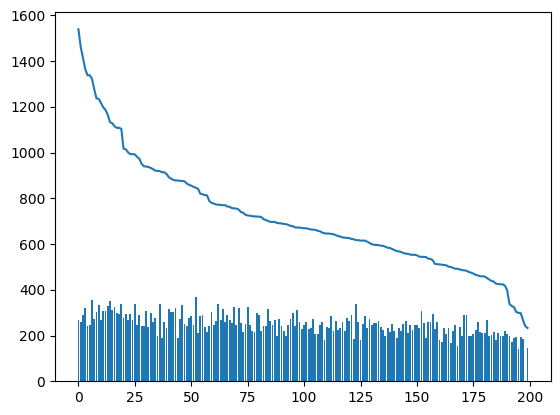

In [203]:

cluster_sizes = {k: v for k, v in zip(*np.unique(Y, return_counts=True))}
plt.bar(clusters, [x.shape[0] for x in ys_per_cluster])\
plt.plot(clusters, np.array(list(cluster_sizes.values())))

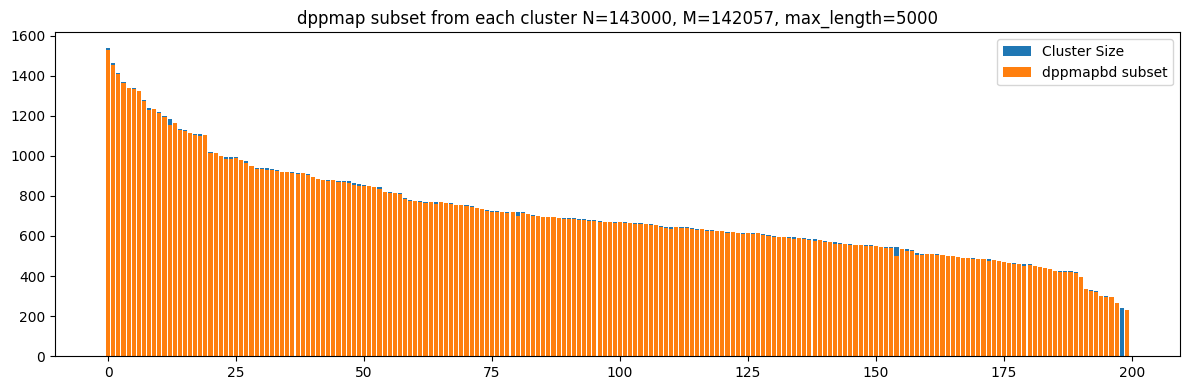

In [204]:
## Plot dpp map subset size w.r.t. clusters 
if isinstance(Y, torch.Tensor):
    Y = Y.to('cpu').numpy()
cluster_sizes = {k: v for k, v in zip(*np.unique(Y, return_counts=True))}
per_cluster_dppmap_subset = {k: v for k, v in zip(*np.unique(Y[inds], return_counts=True))}
xs = list(cluster_sizes.keys())

pct =[0.03, 0.05, 0.1, 0.2, 0.3] 
Ms = [int(x*N) for x in pct]
nrows = len(Ms)

fig, ax = plt.subplots(nrow, 1, figsize=(12,4*nrow), sharex=True)


ys = np.array(list(cluster_sizes.values()))
ax.bar(xs, ys, label='Cluster Size')
if max_length < ys.max():
    plt.axhline(y = max_length, color='r', linestyle='--', label='max_length')
ys  =np.array([per_cluster_dppmap_subset[i] 
            if i in per_cluster_dppmap_subset else 0 for i in xs])
ax.bar(xs, ys, label=f'{dppmap_type} subset')
ax.legend()
ax.set_title(f"dppmap subset from each cluster N={N}, M={info['M']}, max_length={max_length}")
fig.tight_layout()
# save_path = os.path.join(dppmap_save_dir, f'fig_dppmap_subset_wrt_clusters.png')
# fig.savefig(save_path, bbox_inches='tight', dpi=100)
# plt.close()


[4290, 7150, 14300, 28600, 42900]

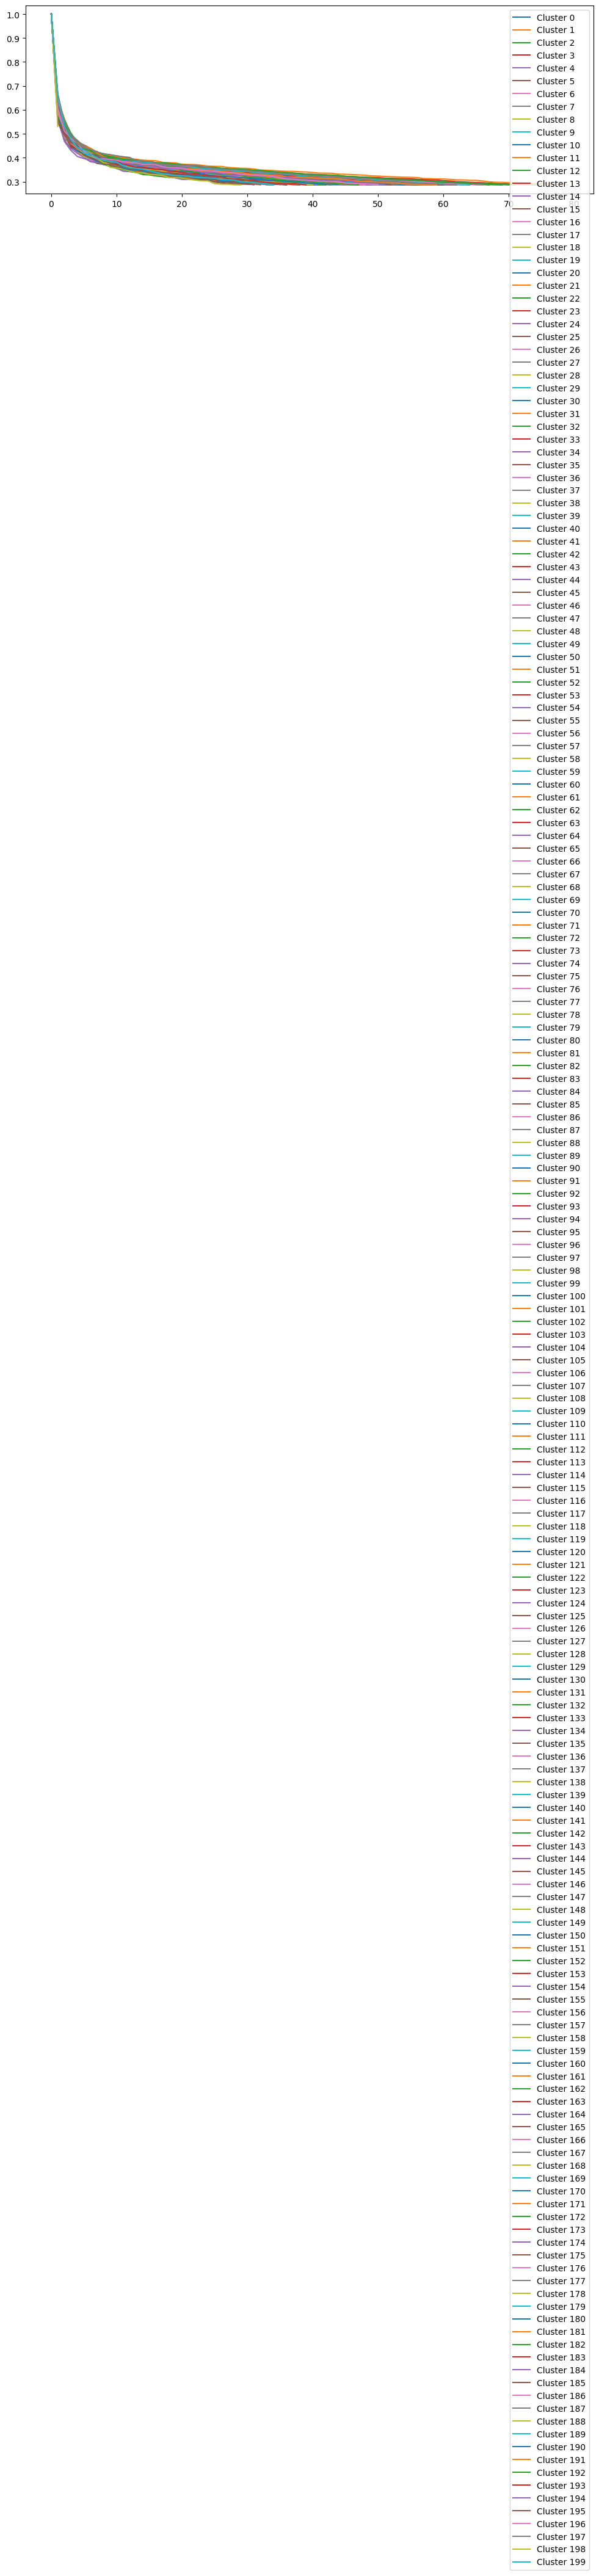

In [189]:


fig, ax = plt.subplots(1,1,figsize=(12, 4))

for i in clusters:
    ax.plot(ys_per_cluster[i], label=f'Cluster {i}')
ax.legend()


In [127]:
from note_pruning_analysis import get_dataset
ds = get_dataset(dataset, processed=True)


In [131]:
inds = np.where(Y==198)[0].tolist()

In [132]:
ds[inds[0]]

{'dataset': 'wizardlm',
 'id': 'wizardlm_mQlSpXY',
 'messages': [{'role': 'user', 'content': ''},
  {'role': 'assistant',
   'content': 'Here are five famous soccer players from Argentina:\r\n\r\n1. Lionel Messi - Often considered one of the greatest soccer players of all time, Messi has spent the majority of his career playing for FC Barcelona, where he has won numerous domestic and international titles. He has also led the Argentine national team to several major tournament finals.\r\n\r\n2. Diego Maradona - Another legendary Argentine soccer player, Maradona played for numerous club teams throughout his career, including FC Barcelona and Napoli. He also led the Argentine national team to victory in the 1986 World Cup.\r\n\r\n3. Gabriel Batistuta - Known for his powerful and accurate shooting, Batistuta played for various club teams in Europe, including Fiorentina and Roma. He also represented Argentina in three World Cups.\r\n\r\n4. Sergio Agüero - A prolific striker, Agüero has pla

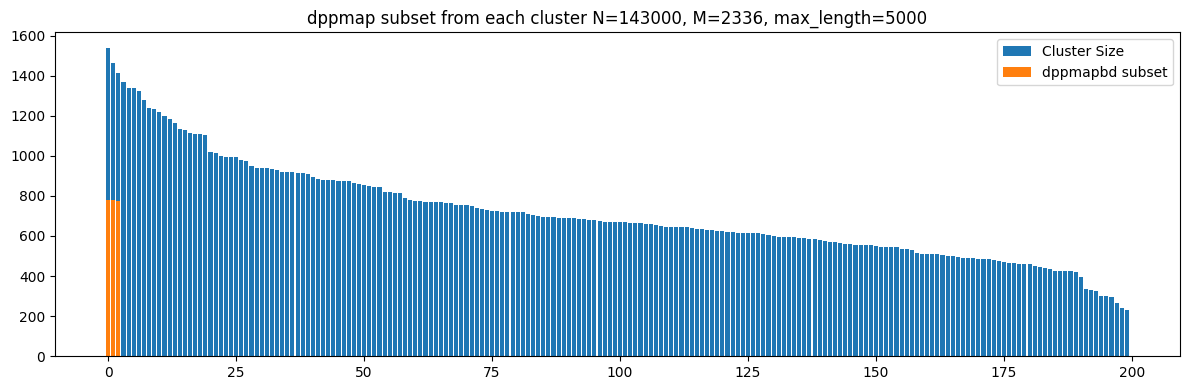

In [118]:
import matplotlib.pyplot as plt


spacings = 1000
fig, ax = plt.subplots(1,1,figsize=(5,5))

for sort_by, info in infos.items():
    print(sort_by)
    M = info['M']
    max_length = info['max_length']
    print(M, max_length)
    ys = info['marginal_gains'][::spacings]
    print(np.array(ys).min())
    ax.plot(ys, label=sort_by)
    
ax.set_xlim((0,200_000/spacings))
ax.legend()

array([781, 780, 775,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [87]:
np.unique(Y, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [91]:
cluster_size

{0: 1539,
 1: 1463,
 2: 1414,
 3: 1366,
 4: 1338,
 5: 1338,
 6: 1323,
 7: 1277,
 8: 1237,
 9: 1235,
 10: 1217,
 11: 1198,
 12: 1186,
 13: 1165,
 14: 1133,
 15: 1128,
 16: 1115,
 17: 1108,
 18: 1108,
 19: 1104,
 20: 1017,
 21: 1014,
 22: 1001,
 23: 993,
 24: 993,
 25: 992,
 26: 981,
 27: 973,
 28: 951,
 29: 940,
 30: 939,
 31: 937,
 32: 933,
 33: 928,
 34: 921,
 35: 920,
 36: 919,
 37: 914,
 38: 914,
 39: 907,
 40: 893,
 41: 886,
 42: 881,
 43: 878,
 44: 878,
 45: 876,
 46: 876,
 47: 874,
 48: 865,
 49: 859,
 50: 855,
 51: 850,
 52: 846,
 53: 842,
 54: 820,
 55: 818,
 56: 814,
 57: 813,
 58: 788,
 59: 780,
 60: 777,
 61: 773,
 62: 772,
 63: 771,
 64: 770,
 65: 770,
 66: 764,
 67: 763,
 68: 757,
 69: 756,
 70: 755,
 71: 751,
 72: 740,
 73: 737,
 74: 728,
 75: 725,
 76: 724,
 77: 722,
 78: 721,
 79: 720,
 80: 720,
 81: 718,
 82: 709,
 83: 705,
 84: 701,
 85: 697,
 86: 697,
 87: 697,
 88: 692,
 89: 691,
 90: 690,
 91: 688,
 92: 687,
 93: 684,
 94: 679,
 95: 678,
 96: 673,
 97: 672,
 98: 67

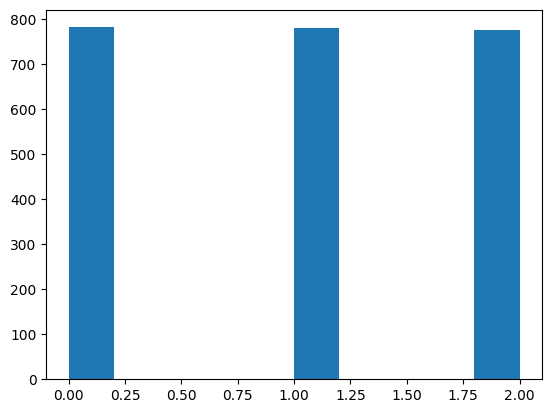

In [75]:
## distribution of points from each cluster
if Y is not None:
    plt.hist(Y[inds])
    
    




In [59]:
dppmap_save_dir = os.path.join('dpp', dataset, run_name)
os.makedirs(dppmap_save_dir, exist_ok=True)

with open(os.path.join(dppmap_save_dir, 'info.json'), 'w') as f:
    json.dump(info, f, ensure_ascii=False, indent=4)
    
with open(os.path.join(dppmap_save_dir, 'data.pkl'), 'wb') as f:
    pickle.dump(data, f)

'dppmapbd_nc=200_k=lin_kmd=mpnet'

In [110]:

# from note_pruning import save_prune_results
if not any(sort_by.startswith(x) for x in ['rho', 'numtoks']):
    save_prune_results(save_dir, inds, S, pkl_extra, sort_by, model_name, dataset)

50000